# IMPORTS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import math, numpy as np
import matplotlib.pyplot as plt

# DATASETS

In [ ]:
from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

drive.mount('/content/drive')

# CIFAR-100: mean/std for normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True,
                             download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False,
                            download=True, transform=transform_test)

train_loader = DataLoader(trainset, batch_size=128,
                          shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=128,
                         shuffle=False, num_workers=4)

Mounted at /content/drive


100%|██████████| 169M/169M [00:03<00:00, 42.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Loops

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.2f}%'})
    return total_loss / total, 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        pbar = tqdm(loader)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.2f}%'})
    return total_loss / total, 100. * correct / total


# TEACHER FINE-TUNING

## TEACHER VGG16

In [ ]:
teacher = models.vgg16(weights="IMAGENET1K_V1")
teacher.classifier[6] = nn.Linear(4096, 100)
teacher = teacher.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 75.2MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
best_acc = 0.0
epochs = 200

In [ ]:
save_path = '/content/drive/MyDrive/stuff/teacher_vgg16_cifar100.pth'

In [ ]:
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(teacher, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(teacher, test_loader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch+1:03d}: "
          f"Train Acc {train_acc:.2f}%, Test Acc {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(teacher.state_dict(), save_path)

print(f"Best Test Acc: {best_acc:.2f}% | Model saved to {save_path}")


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 79/79 [00:02<00:00, 28.11it/s, loss=1.916, acc=47.36%]


Epoch 001: Train Acc 30.31%, Test Acc 47.36%


100%|██████████| 79/79 [00:02<00:00, 28.05it/s, loss=1.742, acc=52.21%]


Epoch 002: Train Acc 47.17%, Test Acc 52.21%


100%|██████████| 79/79 [00:04<00:00, 17.73it/s, loss=1.607, acc=55.35%]


Epoch 003: Train Acc 53.84%, Test Acc 55.35%


100%|██████████| 79/79 [00:03<00:00, 22.88it/s, loss=1.514, acc=58.02%]


Epoch 004: Train Acc 57.90%, Test Acc 58.02%


100%|██████████| 79/79 [00:03<00:00, 23.70it/s, loss=1.452, acc=59.80%]


Epoch 005: Train Acc 60.99%, Test Acc 59.80%


100%|██████████| 79/79 [00:04<00:00, 17.33it/s, loss=1.426, acc=60.75%]


Epoch 006: Train Acc 63.62%, Test Acc 60.75%


100%|██████████| 79/79 [00:03<00:00, 24.34it/s, loss=1.418, acc=61.57%]


Epoch 007: Train Acc 66.25%, Test Acc 61.57%


100%|██████████| 79/79 [00:03<00:00, 25.28it/s, loss=1.442, acc=60.55%]


Epoch 008: Train Acc 67.52%, Test Acc 60.55%


100%|██████████| 79/79 [00:02<00:00, 28.98it/s, loss=1.359, acc=63.62%]


Epoch 009: Train Acc 69.55%, Test Acc 63.62%


100%|██████████| 79/79 [00:03<00:00, 19.77it/s, loss=1.381, acc=62.86%]


Epoch 010: Train Acc 70.99%, Test Acc 62.86%


100%|██████████| 79/79 [00:03<00:00, 23.63it/s, loss=1.363, acc=63.44%]


Epoch 011: Train Acc 72.05%, Test Acc 63.44%


100%|██████████| 79/79 [00:02<00:00, 26.95it/s, loss=1.321, acc=65.12%]


Epoch 012: Train Acc 73.09%, Test Acc 65.12%


100%|██████████| 79/79 [00:04<00:00, 18.83it/s, loss=1.381, acc=64.53%]


Epoch 013: Train Acc 74.73%, Test Acc 64.53%


100%|██████████| 79/79 [00:03<00:00, 21.69it/s, loss=1.362, acc=64.08%]


Epoch 014: Train Acc 75.43%, Test Acc 64.08%


100%|██████████| 79/79 [00:03<00:00, 20.61it/s, loss=1.305, acc=65.17%]


Epoch 015: Train Acc 76.86%, Test Acc 65.17%


100%|██████████| 79/79 [00:03<00:00, 23.98it/s, loss=1.303, acc=66.03%]


Epoch 016: Train Acc 77.25%, Test Acc 66.03%


100%|██████████| 79/79 [00:03<00:00, 24.14it/s, loss=1.305, acc=66.06%]


Epoch 017: Train Acc 78.53%, Test Acc 66.06%


100%|██████████| 79/79 [00:04<00:00, 17.88it/s, loss=1.380, acc=64.95%]


Epoch 018: Train Acc 79.10%, Test Acc 64.95%


100%|██████████| 79/79 [00:03<00:00, 21.01it/s, loss=1.344, acc=65.89%]


Epoch 019: Train Acc 79.55%, Test Acc 65.89%


100%|██████████| 79/79 [00:03<00:00, 20.05it/s, loss=1.423, acc=64.72%]


Epoch 020: Train Acc 80.41%, Test Acc 64.72%


100%|██████████| 79/79 [00:03<00:00, 20.26it/s, loss=1.338, acc=65.61%]


Epoch 021: Train Acc 81.26%, Test Acc 65.61%


100%|██████████| 79/79 [00:03<00:00, 23.79it/s, loss=1.350, acc=65.98%]


Epoch 022: Train Acc 81.57%, Test Acc 65.98%


100%|██████████| 79/79 [00:02<00:00, 27.96it/s, loss=1.439, acc=64.15%]


Epoch 023: Train Acc 82.15%, Test Acc 64.15%


100%|██████████| 79/79 [00:02<00:00, 28.78it/s, loss=1.357, acc=66.24%]


Epoch 024: Train Acc 83.00%, Test Acc 66.24%


100%|██████████| 79/79 [00:04<00:00, 18.70it/s, loss=1.385, acc=65.70%]


Epoch 025: Train Acc 83.36%, Test Acc 65.70%


100%|██████████| 79/79 [00:03<00:00, 21.51it/s, loss=1.367, acc=66.37%]


Epoch 026: Train Acc 83.66%, Test Acc 66.37%


100%|██████████| 79/79 [00:03<00:00, 23.02it/s, loss=1.430, acc=65.40%]


Epoch 027: Train Acc 84.32%, Test Acc 65.40%


100%|██████████| 79/79 [00:03<00:00, 26.27it/s, loss=1.407, acc=65.97%]


Epoch 028: Train Acc 85.22%, Test Acc 65.97%


100%|██████████| 79/79 [00:03<00:00, 23.21it/s, loss=1.396, acc=66.73%]


Epoch 029: Train Acc 85.42%, Test Acc 66.73%


100%|██████████| 79/79 [00:03<00:00, 24.91it/s, loss=1.422, acc=66.37%]


Epoch 030: Train Acc 85.62%, Test Acc 66.37%


100%|██████████| 79/79 [00:02<00:00, 28.20it/s, loss=1.437, acc=65.87%]


Epoch 031: Train Acc 85.90%, Test Acc 65.87%


100%|██████████| 79/79 [00:03<00:00, 24.07it/s, loss=1.452, acc=65.82%]


Epoch 032: Train Acc 86.33%, Test Acc 65.82%


100%|██████████| 79/79 [00:03<00:00, 21.26it/s, loss=1.441, acc=67.15%]


Epoch 033: Train Acc 86.89%, Test Acc 67.15%


100%|██████████| 79/79 [00:03<00:00, 23.66it/s, loss=1.417, acc=68.00%]


Epoch 034: Train Acc 87.06%, Test Acc 68.00%


100%|██████████| 79/79 [00:03<00:00, 24.40it/s, loss=1.589, acc=65.48%]


Epoch 035: Train Acc 87.24%, Test Acc 65.48%


100%|██████████| 79/79 [00:02<00:00, 28.55it/s, loss=1.442, acc=66.83%]


Epoch 036: Train Acc 87.56%, Test Acc 66.83%


100%|██████████| 79/79 [00:02<00:00, 29.05it/s, loss=1.417, acc=67.48%]


Epoch 037: Train Acc 87.94%, Test Acc 67.48%


100%|██████████| 79/79 [00:02<00:00, 28.50it/s, loss=1.446, acc=65.83%]


Epoch 038: Train Acc 88.39%, Test Acc 65.83%


100%|██████████| 79/79 [00:02<00:00, 27.78it/s, loss=1.457, acc=66.67%]


Epoch 039: Train Acc 88.67%, Test Acc 66.67%


100%|██████████| 79/79 [00:02<00:00, 28.98it/s, loss=1.469, acc=67.53%]


Epoch 040: Train Acc 89.00%, Test Acc 67.53%


100%|██████████| 79/79 [00:02<00:00, 28.90it/s, loss=1.506, acc=66.63%]


Epoch 041: Train Acc 89.55%, Test Acc 66.63%


100%|██████████| 79/79 [00:03<00:00, 24.10it/s, loss=1.488, acc=67.15%]


Epoch 042: Train Acc 89.40%, Test Acc 67.15%


100%|██████████| 79/79 [00:03<00:00, 23.15it/s, loss=1.535, acc=67.52%]


Epoch 043: Train Acc 90.07%, Test Acc 67.52%


100%|██████████| 79/79 [00:03<00:00, 21.41it/s, loss=1.537, acc=66.42%]


Epoch 044: Train Acc 90.26%, Test Acc 66.42%


100%|██████████| 79/79 [00:03<00:00, 21.98it/s, loss=1.500, acc=66.99%]


Epoch 045: Train Acc 90.52%, Test Acc 66.99%


100%|██████████| 79/79 [00:03<00:00, 21.08it/s, loss=1.456, acc=67.99%]


Epoch 046: Train Acc 90.68%, Test Acc 67.99%


100%|██████████| 79/79 [00:03<00:00, 20.31it/s, loss=1.520, acc=67.01%]


Epoch 047: Train Acc 91.27%, Test Acc 67.01%


100%|██████████| 79/79 [00:03<00:00, 20.14it/s, loss=1.524, acc=67.36%]


Epoch 048: Train Acc 91.13%, Test Acc 67.36%


100%|██████████| 79/79 [00:03<00:00, 20.45it/s, loss=1.473, acc=67.89%]


Epoch 049: Train Acc 91.31%, Test Acc 67.89%


100%|██████████| 79/79 [00:03<00:00, 19.85it/s, loss=1.496, acc=67.26%]


Epoch 050: Train Acc 91.74%, Test Acc 67.26%


100%|██████████| 79/79 [00:03<00:00, 22.45it/s, loss=1.519, acc=66.96%]


Epoch 051: Train Acc 91.93%, Test Acc 66.96%


100%|██████████| 79/79 [00:03<00:00, 22.08it/s, loss=1.577, acc=67.15%]


Epoch 052: Train Acc 92.24%, Test Acc 67.15%


100%|██████████| 79/79 [00:03<00:00, 22.91it/s, loss=1.573, acc=66.87%]


Epoch 053: Train Acc 92.33%, Test Acc 66.87%


100%|██████████| 79/79 [00:03<00:00, 24.87it/s, loss=1.616, acc=66.38%]


Epoch 054: Train Acc 92.64%, Test Acc 66.38%


100%|██████████| 79/79 [00:02<00:00, 26.45it/s, loss=1.478, acc=68.98%]


Epoch 055: Train Acc 92.85%, Test Acc 68.98%


100%|██████████| 79/79 [00:04<00:00, 17.48it/s, loss=1.500, acc=68.77%]


Epoch 056: Train Acc 92.88%, Test Acc 68.77%


100%|██████████| 79/79 [00:03<00:00, 21.48it/s, loss=1.569, acc=66.92%]


Epoch 057: Train Acc 93.28%, Test Acc 66.92%


100%|██████████| 79/79 [00:03<00:00, 20.63it/s, loss=1.567, acc=67.26%]


Epoch 058: Train Acc 92.92%, Test Acc 67.26%


100%|██████████| 79/79 [00:03<00:00, 20.61it/s, loss=1.590, acc=67.67%]


Epoch 059: Train Acc 93.23%, Test Acc 67.67%


100%|██████████| 79/79 [00:03<00:00, 21.81it/s, loss=1.606, acc=67.88%]


Epoch 060: Train Acc 93.87%, Test Acc 67.88%


100%|██████████| 79/79 [00:03<00:00, 22.39it/s, loss=1.560, acc=68.72%]


Epoch 061: Train Acc 93.62%, Test Acc 68.72%


100%|██████████| 79/79 [00:03<00:00, 24.85it/s, loss=1.557, acc=68.49%]


Epoch 062: Train Acc 94.17%, Test Acc 68.49%


100%|██████████| 79/79 [00:03<00:00, 26.04it/s, loss=1.560, acc=68.17%]


Epoch 063: Train Acc 94.00%, Test Acc 68.17%


100%|██████████| 79/79 [00:02<00:00, 28.02it/s, loss=1.546, acc=68.21%]


Epoch 064: Train Acc 94.38%, Test Acc 68.21%


100%|██████████| 79/79 [00:02<00:00, 28.59it/s, loss=1.648, acc=66.91%]


Epoch 065: Train Acc 94.66%, Test Acc 66.91%


100%|██████████| 79/79 [00:02<00:00, 28.21it/s, loss=1.653, acc=67.61%]


Epoch 066: Train Acc 94.59%, Test Acc 67.61%


100%|██████████| 79/79 [00:02<00:00, 28.77it/s, loss=1.689, acc=66.84%]


Epoch 067: Train Acc 94.40%, Test Acc 66.84%


100%|██████████| 79/79 [00:02<00:00, 28.45it/s, loss=1.669, acc=67.55%]


Epoch 068: Train Acc 94.91%, Test Acc 67.55%


100%|██████████| 79/79 [00:02<00:00, 29.22it/s, loss=1.562, acc=68.19%]


Epoch 069: Train Acc 95.01%, Test Acc 68.19%


100%|██████████| 79/79 [00:02<00:00, 27.74it/s, loss=1.643, acc=68.08%]


Epoch 070: Train Acc 94.86%, Test Acc 68.08%


100%|██████████| 79/79 [00:02<00:00, 28.11it/s, loss=1.617, acc=68.33%]


Epoch 071: Train Acc 95.52%, Test Acc 68.33%


100%|██████████| 79/79 [00:03<00:00, 25.52it/s, loss=1.558, acc=68.86%]


Epoch 072: Train Acc 95.57%, Test Acc 68.86%


100%|██████████| 79/79 [00:03<00:00, 23.02it/s, loss=1.657, acc=67.53%]


Epoch 073: Train Acc 95.63%, Test Acc 67.53%


100%|██████████| 79/79 [00:03<00:00, 21.90it/s, loss=1.622, acc=68.66%]


Epoch 074: Train Acc 96.15%, Test Acc 68.66%


100%|██████████| 79/79 [00:03<00:00, 21.35it/s, loss=1.712, acc=67.15%]


Epoch 075: Train Acc 95.92%, Test Acc 67.15%


100%|██████████| 79/79 [00:03<00:00, 20.29it/s, loss=1.606, acc=68.19%]


Epoch 076: Train Acc 95.85%, Test Acc 68.19%


100%|██████████| 79/79 [00:03<00:00, 19.87it/s, loss=1.673, acc=68.22%]


Epoch 077: Train Acc 96.31%, Test Acc 68.22%


100%|██████████| 79/79 [00:03<00:00, 23.55it/s, loss=1.586, acc=68.92%]


Epoch 078: Train Acc 96.09%, Test Acc 68.92%


100%|██████████| 79/79 [00:03<00:00, 24.75it/s, loss=1.625, acc=67.96%]


Epoch 079: Train Acc 96.19%, Test Acc 67.96%


100%|██████████| 79/79 [00:02<00:00, 27.82it/s, loss=1.676, acc=67.58%]


Epoch 080: Train Acc 96.27%, Test Acc 67.58%


100%|██████████| 79/79 [00:02<00:00, 27.86it/s, loss=1.614, acc=68.45%]


Epoch 081: Train Acc 96.75%, Test Acc 68.45%


100%|██████████| 79/79 [00:02<00:00, 27.47it/s, loss=1.598, acc=69.21%]


Epoch 082: Train Acc 96.76%, Test Acc 69.21%


100%|██████████| 79/79 [00:03<00:00, 20.37it/s, loss=1.559, acc=69.64%]


Epoch 083: Train Acc 96.91%, Test Acc 69.64%


100%|██████████| 79/79 [00:03<00:00, 24.23it/s, loss=1.712, acc=67.91%]


Epoch 084: Train Acc 97.22%, Test Acc 67.91%


100%|██████████| 79/79 [00:02<00:00, 28.68it/s, loss=1.653, acc=68.01%]


Epoch 085: Train Acc 97.08%, Test Acc 68.01%


100%|██████████| 79/79 [00:02<00:00, 28.32it/s, loss=1.612, acc=68.70%]


Epoch 086: Train Acc 97.23%, Test Acc 68.70%


100%|██████████| 79/79 [00:02<00:00, 27.94it/s, loss=1.683, acc=69.26%]


Epoch 087: Train Acc 97.45%, Test Acc 69.26%


100%|██████████| 79/79 [00:03<00:00, 25.70it/s, loss=1.657, acc=68.86%]


Epoch 088: Train Acc 97.40%, Test Acc 68.86%


100%|██████████| 79/79 [00:03<00:00, 23.54it/s, loss=1.696, acc=68.82%]


Epoch 089: Train Acc 97.69%, Test Acc 68.82%


100%|██████████| 79/79 [00:03<00:00, 22.77it/s, loss=1.658, acc=68.29%]


Epoch 090: Train Acc 97.71%, Test Acc 68.29%


100%|██████████| 79/79 [00:03<00:00, 21.70it/s, loss=1.633, acc=69.73%]


Epoch 091: Train Acc 97.60%, Test Acc 69.73%


100%|██████████| 79/79 [00:03<00:00, 24.78it/s, loss=1.743, acc=68.43%]


Epoch 092: Train Acc 97.86%, Test Acc 68.43%


100%|██████████| 79/79 [00:02<00:00, 28.22it/s, loss=1.625, acc=69.63%]


Epoch 093: Train Acc 97.74%, Test Acc 69.63%


100%|██████████| 79/79 [00:02<00:00, 28.15it/s, loss=1.677, acc=69.12%]


Epoch 094: Train Acc 98.02%, Test Acc 69.12%


100%|██████████| 79/79 [00:03<00:00, 24.33it/s, loss=1.619, acc=69.52%]


Epoch 095: Train Acc 97.91%, Test Acc 69.52%


100%|██████████| 79/79 [00:03<00:00, 21.92it/s, loss=1.663, acc=69.93%]


Epoch 096: Train Acc 98.18%, Test Acc 69.93%


100%|██████████| 79/79 [00:03<00:00, 25.12it/s, loss=1.730, acc=69.86%]


Epoch 097: Train Acc 98.49%, Test Acc 69.86%


100%|██████████| 79/79 [00:02<00:00, 27.94it/s, loss=1.659, acc=69.73%]


Epoch 098: Train Acc 98.36%, Test Acc 69.73%


100%|██████████| 79/79 [00:02<00:00, 28.25it/s, loss=1.641, acc=70.79%]


Epoch 099: Train Acc 98.33%, Test Acc 70.79%


100%|██████████| 79/79 [00:03<00:00, 24.63it/s, loss=1.643, acc=70.10%]


Epoch 100: Train Acc 98.25%, Test Acc 70.10%


100%|██████████| 79/79 [00:02<00:00, 28.52it/s, loss=1.692, acc=69.83%]


Epoch 101: Train Acc 98.63%, Test Acc 69.83%


100%|██████████| 79/79 [00:02<00:00, 27.62it/s, loss=1.702, acc=69.35%]


Epoch 102: Train Acc 98.62%, Test Acc 69.35%


100%|██████████| 79/79 [00:02<00:00, 28.55it/s, loss=1.685, acc=69.70%]


Epoch 103: Train Acc 98.52%, Test Acc 69.70%


100%|██████████| 79/79 [00:03<00:00, 25.78it/s, loss=1.698, acc=70.48%]


Epoch 104: Train Acc 98.86%, Test Acc 70.48%


100%|██████████| 79/79 [00:03<00:00, 24.30it/s, loss=1.607, acc=71.24%]


Epoch 105: Train Acc 98.82%, Test Acc 71.24%


100%|██████████| 79/79 [00:03<00:00, 23.26it/s, loss=1.713, acc=69.60%]


Epoch 106: Train Acc 98.73%, Test Acc 69.60%


100%|██████████| 79/79 [00:02<00:00, 28.43it/s, loss=1.682, acc=70.44%]


Epoch 107: Train Acc 98.96%, Test Acc 70.44%


100%|██████████| 79/79 [00:02<00:00, 28.66it/s, loss=1.697, acc=70.34%]


Epoch 108: Train Acc 98.87%, Test Acc 70.34%


100%|██████████| 79/79 [00:02<00:00, 28.90it/s, loss=1.666, acc=70.94%]


Epoch 109: Train Acc 98.89%, Test Acc 70.94%


100%|██████████| 79/79 [00:02<00:00, 28.45it/s, loss=1.689, acc=70.11%]


Epoch 110: Train Acc 98.88%, Test Acc 70.11%


100%|██████████| 79/79 [00:02<00:00, 28.66it/s, loss=1.680, acc=70.71%]


Epoch 111: Train Acc 98.98%, Test Acc 70.71%


100%|██████████| 79/79 [00:02<00:00, 27.21it/s, loss=1.741, acc=70.30%]


Epoch 112: Train Acc 99.10%, Test Acc 70.30%


100%|██████████| 79/79 [00:03<00:00, 23.38it/s, loss=1.694, acc=70.94%]


Epoch 113: Train Acc 99.13%, Test Acc 70.94%


100%|██████████| 79/79 [00:03<00:00, 21.68it/s, loss=1.697, acc=70.41%]


Epoch 114: Train Acc 99.28%, Test Acc 70.41%


100%|██████████| 79/79 [00:03<00:00, 20.34it/s, loss=1.655, acc=70.43%]


Epoch 115: Train Acc 99.15%, Test Acc 70.43%


100%|██████████| 79/79 [00:03<00:00, 20.42it/s, loss=1.668, acc=71.23%]


Epoch 116: Train Acc 99.26%, Test Acc 71.23%


100%|██████████| 79/79 [00:03<00:00, 19.85it/s, loss=1.737, acc=70.72%]


Epoch 117: Train Acc 99.42%, Test Acc 70.72%


100%|██████████| 79/79 [00:03<00:00, 20.34it/s, loss=1.685, acc=70.73%]


Epoch 118: Train Acc 99.23%, Test Acc 70.73%


100%|██████████| 79/79 [00:03<00:00, 22.87it/s, loss=1.667, acc=70.78%]


Epoch 119: Train Acc 99.33%, Test Acc 70.78%


100%|██████████| 79/79 [00:03<00:00, 22.96it/s, loss=1.682, acc=71.16%]


Epoch 120: Train Acc 99.38%, Test Acc 71.16%


100%|██████████| 79/79 [00:03<00:00, 23.72it/s, loss=1.687, acc=71.47%]


Epoch 121: Train Acc 99.48%, Test Acc 71.47%


100%|██████████| 79/79 [00:04<00:00, 18.88it/s, loss=1.698, acc=71.16%]


Epoch 122: Train Acc 99.47%, Test Acc 71.16%


100%|██████████| 79/79 [00:03<00:00, 23.95it/s, loss=1.735, acc=70.59%]


Epoch 123: Train Acc 99.50%, Test Acc 70.59%


100%|██████████| 79/79 [00:03<00:00, 21.38it/s, loss=1.718, acc=71.31%]


Epoch 124: Train Acc 99.50%, Test Acc 71.31%


100%|██████████| 79/79 [00:03<00:00, 21.49it/s, loss=1.691, acc=71.36%]


Epoch 125: Train Acc 99.43%, Test Acc 71.36%


100%|██████████| 79/79 [00:03<00:00, 21.40it/s, loss=1.707, acc=71.83%]


Epoch 126: Train Acc 99.54%, Test Acc 71.83%


100%|██████████| 79/79 [00:03<00:00, 24.01it/s, loss=1.690, acc=71.33%]


Epoch 127: Train Acc 99.60%, Test Acc 71.33%


100%|██████████| 79/79 [00:02<00:00, 28.08it/s, loss=1.684, acc=71.47%]


Epoch 128: Train Acc 99.64%, Test Acc 71.47%


100%|██████████| 79/79 [00:03<00:00, 23.79it/s, loss=1.732, acc=71.25%]


Epoch 129: Train Acc 99.69%, Test Acc 71.25%


100%|██████████| 79/79 [00:03<00:00, 24.40it/s, loss=1.734, acc=71.65%]


Epoch 130: Train Acc 99.67%, Test Acc 71.65%


100%|██████████| 79/79 [00:03<00:00, 22.96it/s, loss=1.701, acc=71.52%]


Epoch 131: Train Acc 99.63%, Test Acc 71.52%


100%|██████████| 79/79 [00:03<00:00, 21.22it/s, loss=1.763, acc=71.51%]


Epoch 132: Train Acc 99.73%, Test Acc 71.51%


100%|██████████| 79/79 [00:03<00:00, 20.71it/s, loss=1.715, acc=71.29%]


Epoch 133: Train Acc 99.61%, Test Acc 71.29%


100%|██████████| 79/79 [00:03<00:00, 20.27it/s, loss=1.670, acc=71.53%]


Epoch 134: Train Acc 99.63%, Test Acc 71.53%


100%|██████████| 79/79 [00:03<00:00, 20.44it/s, loss=1.746, acc=71.00%]


Epoch 135: Train Acc 99.73%, Test Acc 71.00%


100%|██████████| 79/79 [00:04<00:00, 19.73it/s, loss=1.784, acc=70.85%]


Epoch 136: Train Acc 99.71%, Test Acc 70.85%


100%|██████████| 79/79 [00:03<00:00, 20.18it/s, loss=1.733, acc=71.62%]


Epoch 137: Train Acc 99.75%, Test Acc 71.62%


100%|██████████| 79/79 [00:03<00:00, 21.47it/s, loss=1.726, acc=71.57%]


Epoch 138: Train Acc 99.76%, Test Acc 71.57%


100%|██████████| 79/79 [00:03<00:00, 23.62it/s, loss=1.722, acc=71.83%]


Epoch 139: Train Acc 99.80%, Test Acc 71.83%


100%|██████████| 79/79 [00:03<00:00, 24.28it/s, loss=1.738, acc=71.43%]


Epoch 140: Train Acc 99.72%, Test Acc 71.43%


100%|██████████| 79/79 [00:03<00:00, 25.86it/s, loss=1.764, acc=71.70%]


Epoch 141: Train Acc 99.80%, Test Acc 71.70%


100%|██████████| 79/79 [00:02<00:00, 27.16it/s, loss=1.742, acc=71.57%]


Epoch 142: Train Acc 99.77%, Test Acc 71.57%


100%|██████████| 79/79 [00:02<00:00, 27.51it/s, loss=1.782, acc=71.45%]


Epoch 143: Train Acc 99.80%, Test Acc 71.45%


100%|██████████| 79/79 [00:02<00:00, 26.92it/s, loss=1.738, acc=71.56%]


Epoch 144: Train Acc 99.81%, Test Acc 71.56%


100%|██████████| 79/79 [00:02<00:00, 26.67it/s, loss=1.744, acc=71.50%]


Epoch 145: Train Acc 99.81%, Test Acc 71.50%


100%|██████████| 79/79 [00:02<00:00, 27.94it/s, loss=1.752, acc=71.81%]


Epoch 146: Train Acc 99.87%, Test Acc 71.81%


100%|██████████| 79/79 [00:02<00:00, 27.83it/s, loss=1.737, acc=71.98%]


Epoch 147: Train Acc 99.78%, Test Acc 71.98%


100%|██████████| 79/79 [00:03<00:00, 23.98it/s, loss=1.748, acc=72.03%]


Epoch 148: Train Acc 99.85%, Test Acc 72.03%


100%|██████████| 79/79 [00:03<00:00, 23.28it/s, loss=1.753, acc=72.24%]


Epoch 149: Train Acc 99.85%, Test Acc 72.24%


100%|██████████| 79/79 [00:04<00:00, 17.07it/s, loss=1.761, acc=71.84%]


Epoch 150: Train Acc 99.84%, Test Acc 71.84%


100%|██████████| 79/79 [00:03<00:00, 20.41it/s, loss=1.779, acc=71.97%]


Epoch 151: Train Acc 99.84%, Test Acc 71.97%


100%|██████████| 79/79 [00:04<00:00, 19.22it/s, loss=1.756, acc=71.57%]


Epoch 152: Train Acc 99.83%, Test Acc 71.57%


100%|██████████| 79/79 [00:03<00:00, 20.38it/s, loss=1.761, acc=71.94%]


Epoch 153: Train Acc 99.85%, Test Acc 71.94%


100%|██████████| 79/79 [00:03<00:00, 21.02it/s, loss=1.800, acc=71.98%]


Epoch 154: Train Acc 99.88%, Test Acc 71.98%


100%|██████████| 79/79 [00:03<00:00, 22.61it/s, loss=1.784, acc=71.87%]


Epoch 155: Train Acc 99.86%, Test Acc 71.87%


100%|██████████| 79/79 [00:03<00:00, 25.32it/s, loss=1.803, acc=71.72%]


Epoch 156: Train Acc 99.88%, Test Acc 71.72%


100%|██████████| 79/79 [00:02<00:00, 27.50it/s, loss=1.830, acc=71.57%]


Epoch 157: Train Acc 99.86%, Test Acc 71.57%


100%|██████████| 79/79 [00:02<00:00, 27.02it/s, loss=1.810, acc=71.87%]


Epoch 158: Train Acc 99.86%, Test Acc 71.87%


100%|██████████| 79/79 [00:02<00:00, 27.17it/s, loss=1.806, acc=71.94%]


Epoch 159: Train Acc 99.88%, Test Acc 71.94%


100%|██████████| 79/79 [00:02<00:00, 27.66it/s, loss=1.800, acc=72.01%]


Epoch 160: Train Acc 99.90%, Test Acc 72.01%


100%|██████████| 79/79 [00:02<00:00, 28.15it/s, loss=1.780, acc=72.05%]


Epoch 161: Train Acc 99.87%, Test Acc 72.05%


100%|██████████| 79/79 [00:02<00:00, 26.89it/s, loss=1.805, acc=72.11%]


Epoch 162: Train Acc 99.90%, Test Acc 72.11%


100%|██████████| 79/79 [00:02<00:00, 27.48it/s, loss=1.815, acc=72.00%]


Epoch 163: Train Acc 99.90%, Test Acc 72.00%


100%|██████████| 79/79 [00:03<00:00, 23.96it/s, loss=1.826, acc=71.91%]


Epoch 164: Train Acc 99.91%, Test Acc 71.91%


100%|██████████| 79/79 [00:03<00:00, 22.11it/s, loss=1.825, acc=71.51%]


Epoch 165: Train Acc 99.88%, Test Acc 71.51%


100%|██████████| 79/79 [00:03<00:00, 20.50it/s, loss=1.814, acc=72.04%]


Epoch 166: Train Acc 99.90%, Test Acc 72.04%


100%|██████████| 79/79 [00:03<00:00, 20.05it/s, loss=1.792, acc=71.91%]


Epoch 167: Train Acc 99.88%, Test Acc 71.91%


100%|██████████| 79/79 [00:03<00:00, 20.94it/s, loss=1.839, acc=71.96%]


Epoch 168: Train Acc 99.92%, Test Acc 71.96%


100%|██████████| 79/79 [00:03<00:00, 21.84it/s, loss=1.836, acc=71.83%]


Epoch 169: Train Acc 99.92%, Test Acc 71.83%


100%|██████████| 79/79 [00:03<00:00, 24.62it/s, loss=1.830, acc=71.74%]


Epoch 170: Train Acc 99.88%, Test Acc 71.74%


100%|██████████| 79/79 [00:02<00:00, 27.85it/s, loss=1.857, acc=72.08%]


Epoch 171: Train Acc 99.92%, Test Acc 72.08%


100%|██████████| 79/79 [00:02<00:00, 27.41it/s, loss=1.834, acc=71.94%]


Epoch 172: Train Acc 99.93%, Test Acc 71.94%


100%|██████████| 79/79 [00:02<00:00, 27.66it/s, loss=1.866, acc=71.91%]


Epoch 173: Train Acc 99.92%, Test Acc 71.91%


100%|██████████| 79/79 [00:02<00:00, 27.13it/s, loss=1.848, acc=71.90%]


Epoch 174: Train Acc 99.90%, Test Acc 71.90%


100%|██████████| 79/79 [00:02<00:00, 26.96it/s, loss=1.840, acc=71.96%]


Epoch 175: Train Acc 99.93%, Test Acc 71.96%


100%|██████████| 79/79 [00:02<00:00, 27.73it/s, loss=1.854, acc=72.12%]


Epoch 176: Train Acc 99.92%, Test Acc 72.12%


100%|██████████| 79/79 [00:03<00:00, 25.63it/s, loss=1.832, acc=72.00%]


Epoch 177: Train Acc 99.92%, Test Acc 72.00%


100%|██████████| 79/79 [00:03<00:00, 21.62it/s, loss=1.865, acc=71.88%]


Epoch 178: Train Acc 99.92%, Test Acc 71.88%


100%|██████████| 79/79 [00:03<00:00, 21.17it/s, loss=1.854, acc=72.20%]


Epoch 179: Train Acc 99.92%, Test Acc 72.20%


100%|██████████| 79/79 [00:04<00:00, 19.72it/s, loss=1.865, acc=72.05%]


Epoch 180: Train Acc 99.94%, Test Acc 72.05%


100%|██████████| 79/79 [00:03<00:00, 19.86it/s, loss=1.877, acc=72.01%]


Epoch 181: Train Acc 99.92%, Test Acc 72.01%


100%|██████████| 79/79 [00:03<00:00, 20.08it/s, loss=1.867, acc=72.08%]


Epoch 182: Train Acc 99.92%, Test Acc 72.08%


100%|██████████| 79/79 [00:03<00:00, 20.81it/s, loss=1.874, acc=72.09%]


Epoch 183: Train Acc 99.93%, Test Acc 72.09%


100%|██████████| 79/79 [00:03<00:00, 23.97it/s, loss=1.866, acc=71.98%]


Epoch 184: Train Acc 99.92%, Test Acc 71.98%


100%|██████████| 79/79 [00:03<00:00, 26.31it/s, loss=1.872, acc=72.08%]


Epoch 185: Train Acc 99.93%, Test Acc 72.08%


100%|██████████| 79/79 [00:03<00:00, 25.22it/s, loss=1.861, acc=72.01%]


Epoch 186: Train Acc 99.93%, Test Acc 72.01%


100%|██████████| 79/79 [00:02<00:00, 26.83it/s, loss=1.863, acc=72.10%]


Epoch 187: Train Acc 99.92%, Test Acc 72.10%


100%|██████████| 79/79 [00:02<00:00, 26.76it/s, loss=1.872, acc=72.03%]


Epoch 188: Train Acc 99.92%, Test Acc 72.03%


100%|██████████| 79/79 [00:02<00:00, 26.42it/s, loss=1.868, acc=71.96%]


Epoch 189: Train Acc 99.95%, Test Acc 71.96%


100%|██████████| 79/79 [00:02<00:00, 26.76it/s, loss=1.873, acc=71.98%]


Epoch 190: Train Acc 99.94%, Test Acc 71.98%


100%|██████████| 79/79 [00:03<00:00, 23.92it/s, loss=1.873, acc=72.09%]


Epoch 191: Train Acc 99.95%, Test Acc 72.09%


100%|██████████| 79/79 [00:03<00:00, 21.98it/s, loss=1.869, acc=71.93%]


Epoch 192: Train Acc 99.92%, Test Acc 71.93%


100%|██████████| 79/79 [00:03<00:00, 20.89it/s, loss=1.873, acc=71.97%]


Epoch 193: Train Acc 99.92%, Test Acc 71.97%


100%|██████████| 79/79 [00:03<00:00, 20.43it/s, loss=1.873, acc=72.06%]


Epoch 194: Train Acc 99.94%, Test Acc 72.06%


100%|██████████| 79/79 [00:03<00:00, 21.14it/s, loss=1.874, acc=72.04%]


Epoch 195: Train Acc 99.93%, Test Acc 72.04%


100%|██████████| 79/79 [00:03<00:00, 22.41it/s, loss=1.873, acc=72.05%]


Epoch 196: Train Acc 99.93%, Test Acc 72.05%


100%|██████████| 79/79 [00:03<00:00, 24.57it/s, loss=1.872, acc=72.03%]


Epoch 197: Train Acc 99.93%, Test Acc 72.03%


100%|██████████| 79/79 [00:02<00:00, 26.95it/s, loss=1.872, acc=72.06%]


Epoch 198: Train Acc 99.93%, Test Acc 72.06%


100%|██████████| 79/79 [00:02<00:00, 26.63it/s, loss=1.872, acc=72.08%]


Epoch 199: Train Acc 99.91%, Test Acc 72.08%


100%|██████████| 79/79 [00:02<00:00, 27.70it/s, loss=1.872, acc=72.08%]

Epoch 200: Train Acc 99.93%, Test Acc 72.08%
Best Test Acc: 72.24% | Model saved to /content/drive/MyDrive/stuff/teacher_vgg16_cifar100.pth


In [ ]:
# rebuild identical model structure
teacher = models.vgg16(weights=None)
teacher.classifier[6] = nn.Linear(4096, 100)

# load weights
state_dict = torch.load('/content/drive/MyDrive/stuff/teacher_vgg16_cifar100.pth', map_location=device)
teacher.load_state_dict(state_dict)

teacher = teacher.to(device)
teacher.eval()

print(teacher)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
test_loss, test_acc = evaluate(teacher, test_loader, criterion, device)
print(f"Val Loss: {test_loss:.4f} | Val Accuracy: {test_acc:.2f}%")

100%|██████████| 79/79 [00:03<00:00, 20.67it/s, loss=1.753, acc=72.24%]

Val Loss: 1.7532 | Val Accuracy: 72.24%


## TEACHER VGG19

In [ ]:
teacher_19 = models.vgg19(weights="IMAGENET1K_V1")
teacher_19.classifier[6] = nn.Linear(4096, 100)
teacher_19 = teacher_19.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 76.1MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(teacher_19.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=250)

In [ ]:
best_acc = 0.0
epochs = 250
save_path = '/content/drive/MyDrive/stuff/teacher_vgg19_cifar100.pth'

In [ ]:
test_acc = 0
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(teacher_19, train_loader, optimizer, criterion, device)
    if epoch > 150:
        test_loss, test_acc = evaluate(teacher_19, test_loader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch+1:03d}: "
          f"Train Acc {train_acc:.2f}%, Test Acc {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(teacher_19.state_dict(), save_path)

print(f"Best Test Acc: {best_acc:.2f}% | Model saved to {save_path}")


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 391/391 [00:44<00:00,  8.75it/s, loss=2.690, acc=31.66%]


Epoch 001: Train Acc 31.66%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=1.974, acc=46.75%]


Epoch 002: Train Acc 46.75%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.58it/s, loss=1.708, acc=53.14%]


Epoch 003: Train Acc 53.14%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.51it/s, loss=1.542, acc=57.51%]


Epoch 004: Train Acc 57.51%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.55it/s, loss=1.453, acc=59.59%]


Epoch 005: Train Acc 59.59%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.52it/s, loss=1.328, acc=62.61%]


Epoch 006: Train Acc 62.61%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.56it/s, loss=1.266, acc=64.27%]


Epoch 007: Train Acc 64.27%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.59it/s, loss=1.192, acc=65.97%]


Epoch 008: Train Acc 65.97%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.55it/s, loss=1.120, acc=68.10%]


Epoch 009: Train Acc 68.10%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.51it/s, loss=1.097, acc=68.53%]


Epoch 010: Train Acc 68.53%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.57it/s, loss=1.030, acc=70.61%]


Epoch 011: Train Acc 70.61%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.56it/s, loss=0.996, acc=71.26%]


Epoch 012: Train Acc 71.26%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.949, acc=72.58%]


Epoch 013: Train Acc 72.58%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.920, acc=73.37%]


Epoch 014: Train Acc 73.37%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.878, acc=74.37%]


Epoch 015: Train Acc 74.37%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.57it/s, loss=0.848, acc=75.48%]


Epoch 016: Train Acc 75.48%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.56it/s, loss=0.818, acc=76.02%]


Epoch 017: Train Acc 76.02%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.792, acc=77.11%]


Epoch 018: Train Acc 77.11%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.764, acc=77.67%]


Epoch 019: Train Acc 77.67%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.746, acc=78.18%]


Epoch 020: Train Acc 78.18%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.53it/s, loss=0.711, acc=78.93%]


Epoch 021: Train Acc 78.93%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.53it/s, loss=0.702, acc=79.47%]


Epoch 022: Train Acc 79.47%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.674, acc=80.06%]


Epoch 023: Train Acc 80.06%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.674, acc=80.18%]


Epoch 024: Train Acc 80.18%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.648, acc=80.76%]


Epoch 025: Train Acc 80.76%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.636, acc=81.31%]


Epoch 026: Train Acc 81.31%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.622, acc=81.45%]


Epoch 027: Train Acc 81.45%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.604, acc=82.10%]


Epoch 028: Train Acc 82.10%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.578, acc=82.78%]


Epoch 029: Train Acc 82.78%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.563, acc=83.25%]


Epoch 030: Train Acc 83.25%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.575, acc=82.98%]


Epoch 031: Train Acc 82.98%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.55it/s, loss=0.544, acc=83.81%]


Epoch 032: Train Acc 83.81%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.525, acc=84.29%]


Epoch 033: Train Acc 84.29%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.520, acc=84.62%]


Epoch 034: Train Acc 84.62%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.503, acc=85.00%]


Epoch 035: Train Acc 85.00%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.493, acc=85.35%]


Epoch 036: Train Acc 85.35%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.490, acc=85.42%]


Epoch 037: Train Acc 85.42%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.53it/s, loss=0.465, acc=86.18%]


Epoch 038: Train Acc 86.18%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.465, acc=86.04%]


Epoch 039: Train Acc 86.04%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.457, acc=86.42%]


Epoch 040: Train Acc 86.42%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.429, acc=87.06%]


Epoch 041: Train Acc 87.06%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.443, acc=86.66%]


Epoch 042: Train Acc 86.66%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.439, acc=86.89%]


Epoch 043: Train Acc 86.89%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.423, acc=87.41%]


Epoch 044: Train Acc 87.41%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.406, acc=87.77%]


Epoch 045: Train Acc 87.77%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.418, acc=87.53%]


Epoch 046: Train Acc 87.53%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.414, acc=87.55%]


Epoch 047: Train Acc 87.55%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.387, acc=88.52%]


Epoch 048: Train Acc 88.52%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.367, acc=88.90%]


Epoch 049: Train Acc 88.90%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.51it/s, loss=0.367, acc=89.07%]


Epoch 050: Train Acc 89.07%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.362, acc=89.12%]


Epoch 051: Train Acc 89.12%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.371, acc=88.87%]


Epoch 052: Train Acc 88.87%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.343, acc=89.65%]


Epoch 053: Train Acc 89.65%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.349, acc=89.42%]


Epoch 054: Train Acc 89.42%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.350, acc=89.48%]


Epoch 055: Train Acc 89.48%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.330, acc=90.19%]


Epoch 056: Train Acc 90.19%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.323, acc=90.40%]


Epoch 057: Train Acc 90.40%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.308, acc=90.83%]


Epoch 058: Train Acc 90.83%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.318, acc=90.50%]


Epoch 059: Train Acc 90.50%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.287, acc=91.44%]


Epoch 060: Train Acc 91.44%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.301, acc=90.95%]


Epoch 061: Train Acc 90.95%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.298, acc=91.01%]


Epoch 062: Train Acc 91.01%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.287, acc=91.42%]


Epoch 063: Train Acc 91.42%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.288, acc=91.32%]


Epoch 064: Train Acc 91.32%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.272, acc=91.87%]


Epoch 065: Train Acc 91.87%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.271, acc=91.97%]


Epoch 066: Train Acc 91.97%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.263, acc=92.04%]


Epoch 067: Train Acc 92.04%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.258, acc=92.28%]


Epoch 068: Train Acc 92.28%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.250, acc=92.37%]


Epoch 069: Train Acc 92.37%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.246, acc=92.49%]


Epoch 070: Train Acc 92.49%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.242, acc=92.85%]


Epoch 071: Train Acc 92.85%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.249, acc=92.50%]


Epoch 072: Train Acc 92.50%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.243, acc=92.74%]


Epoch 073: Train Acc 92.74%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.39it/s, loss=0.225, acc=93.17%]


Epoch 074: Train Acc 93.17%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.214, acc=93.64%]


Epoch 075: Train Acc 93.64%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.223, acc=93.25%]


Epoch 076: Train Acc 93.25%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.224, acc=93.22%]


Epoch 077: Train Acc 93.22%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.219, acc=93.49%]


Epoch 078: Train Acc 93.49%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.204, acc=93.75%]


Epoch 079: Train Acc 93.75%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.203, acc=93.89%]


Epoch 080: Train Acc 93.89%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.39it/s, loss=0.199, acc=94.01%]


Epoch 081: Train Acc 94.01%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.202, acc=93.98%]


Epoch 082: Train Acc 93.98%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.180, acc=94.59%]


Epoch 083: Train Acc 94.59%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.196, acc=94.03%]


Epoch 084: Train Acc 94.03%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.40it/s, loss=0.188, acc=94.34%]


Epoch 085: Train Acc 94.34%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.170, acc=94.98%]


Epoch 086: Train Acc 94.98%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.185, acc=94.41%]


Epoch 087: Train Acc 94.41%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.40it/s, loss=0.172, acc=94.79%]


Epoch 088: Train Acc 94.79%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.36it/s, loss=0.176, acc=94.73%]


Epoch 089: Train Acc 94.73%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.161, acc=95.10%]


Epoch 090: Train Acc 95.10%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.154, acc=95.38%]


Epoch 091: Train Acc 95.38%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.38it/s, loss=0.151, acc=95.52%]


Epoch 092: Train Acc 95.52%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.37it/s, loss=0.165, acc=95.09%]


Epoch 093: Train Acc 95.09%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.146, acc=95.51%]


Epoch 094: Train Acc 95.51%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.147, acc=95.49%]


Epoch 095: Train Acc 95.49%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.140, acc=95.82%]


Epoch 096: Train Acc 95.82%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.40it/s, loss=0.143, acc=95.71%]


Epoch 097: Train Acc 95.71%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.38it/s, loss=0.132, acc=96.01%]


Epoch 098: Train Acc 96.01%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.131, acc=96.07%]


Epoch 099: Train Acc 96.07%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.134, acc=95.84%]


Epoch 100: Train Acc 95.84%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.40it/s, loss=0.124, acc=96.29%]


Epoch 101: Train Acc 96.29%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.133, acc=95.98%]


Epoch 102: Train Acc 95.98%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.111, acc=96.61%]


Epoch 103: Train Acc 96.61%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.39it/s, loss=0.110, acc=96.61%]


Epoch 104: Train Acc 96.61%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.129, acc=96.10%]


Epoch 105: Train Acc 96.10%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.116, acc=96.48%]


Epoch 106: Train Acc 96.48%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.110, acc=96.67%]


Epoch 107: Train Acc 96.67%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.37it/s, loss=0.105, acc=96.73%]


Epoch 108: Train Acc 96.73%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.100, acc=96.94%]


Epoch 109: Train Acc 96.94%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.102, acc=96.87%]


Epoch 110: Train Acc 96.87%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.106, acc=96.69%]


Epoch 111: Train Acc 96.69%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.096, acc=97.12%]


Epoch 112: Train Acc 97.12%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.089, acc=97.27%]


Epoch 113: Train Acc 97.27%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.091, acc=97.13%]


Epoch 114: Train Acc 97.13%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.080, acc=97.52%]


Epoch 115: Train Acc 97.52%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.085, acc=97.42%]


Epoch 116: Train Acc 97.42%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.081, acc=97.49%]


Epoch 117: Train Acc 97.49%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.073, acc=97.84%]


Epoch 118: Train Acc 97.84%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.067, acc=97.99%]


Epoch 119: Train Acc 97.99%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.067, acc=97.94%]


Epoch 120: Train Acc 97.94%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.061, acc=98.17%]


Epoch 121: Train Acc 98.17%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.062, acc=98.11%]


Epoch 122: Train Acc 98.11%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.069, acc=97.85%]


Epoch 123: Train Acc 97.85%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.061, acc=98.16%]


Epoch 124: Train Acc 98.16%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.062, acc=98.15%]


Epoch 125: Train Acc 98.15%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.060, acc=98.15%]


Epoch 126: Train Acc 98.15%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.056, acc=98.25%]


Epoch 127: Train Acc 98.25%, Test Acc 0.00%


100%|██████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.051, acc=98.47%]


Epoch 128: Train Acc 98.47%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.052, acc=98.40%]


Epoch 129: Train Acc 98.40%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.053, acc=98.36%]


Epoch 130: Train Acc 98.36%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.051, acc=98.37%]


Epoch 131: Train Acc 98.37%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.046, acc=98.63%]


Epoch 132: Train Acc 98.63%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.046, acc=98.62%]


Epoch 133: Train Acc 98.62%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.036, acc=98.88%]


Epoch 134: Train Acc 98.88%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.039, acc=98.77%]


Epoch 135: Train Acc 98.77%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.040, acc=98.75%]


Epoch 136: Train Acc 98.75%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.036, acc=98.89%]


Epoch 137: Train Acc 98.89%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.037, acc=98.85%]


Epoch 138: Train Acc 98.85%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.037, acc=98.85%]


Epoch 139: Train Acc 98.85%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.030, acc=99.16%]


Epoch 140: Train Acc 99.16%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.028, acc=99.17%]


Epoch 141: Train Acc 99.17%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.027, acc=99.16%]


Epoch 142: Train Acc 99.16%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.030, acc=99.12%]


Epoch 143: Train Acc 99.12%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.032, acc=99.04%]


Epoch 144: Train Acc 99.04%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.024, acc=99.33%]


Epoch 145: Train Acc 99.33%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.023, acc=99.35%]


Epoch 146: Train Acc 99.35%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.022, acc=99.36%]


Epoch 147: Train Acc 99.36%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.018, acc=99.49%]


Epoch 148: Train Acc 99.49%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.021, acc=99.34%]


Epoch 149: Train Acc 99.34%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.021, acc=99.41%]


Epoch 150: Train Acc 99.41%, Test Acc 0.00%


100%|██████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.022, acc=99.34%]


Epoch 151: Train Acc 99.34%, Test Acc 0.00%


100%|██████████| 79/79 [00:03<00:00, 24.68it/s, loss=1.760, acc=71.08%]


Epoch 152: Train Acc 99.43%, Test Acc 71.08%


100%|██████████| 79/79 [00:03<00:00, 25.84it/s, loss=1.765, acc=71.13%]


Epoch 153: Train Acc 99.41%, Test Acc 71.13%


100%|██████████| 79/79 [00:03<00:00, 24.08it/s, loss=1.740, acc=70.93%]


Epoch 154: Train Acc 99.53%, Test Acc 70.93%


100%|██████████| 79/79 [00:03<00:00, 24.97it/s, loss=1.754, acc=71.18%]


Epoch 155: Train Acc 99.45%, Test Acc 71.18%


100%|██████████| 79/79 [00:04<00:00, 17.90it/s, loss=1.828, acc=70.45%]


Epoch 156: Train Acc 99.58%, Test Acc 70.45%


100%|██████████| 79/79 [00:03<00:00, 25.71it/s, loss=1.821, acc=70.44%]


Epoch 157: Train Acc 99.54%, Test Acc 70.44%


100%|██████████| 79/79 [00:03<00:00, 22.78it/s, loss=1.743, acc=71.88%]


Epoch 158: Train Acc 99.51%, Test Acc 71.88%


100%|██████████| 79/79 [00:04<00:00, 19.35it/s, loss=1.787, acc=71.46%]


Epoch 159: Train Acc 99.66%, Test Acc 71.46%


100%|██████████| 79/79 [00:03<00:00, 25.69it/s, loss=1.740, acc=71.06%]


Epoch 160: Train Acc 99.53%, Test Acc 71.06%


100%|██████████| 79/79 [00:03<00:00, 19.98it/s, loss=1.733, acc=71.54%]


Epoch 161: Train Acc 99.62%, Test Acc 71.54%


100%|██████████| 79/79 [00:03<00:00, 25.21it/s, loss=1.720, acc=71.51%]


Epoch 162: Train Acc 99.60%, Test Acc 71.51%


100%|██████████| 79/79 [00:03<00:00, 21.87it/s, loss=1.771, acc=71.48%]


Epoch 163: Train Acc 99.72%, Test Acc 71.48%


100%|██████████| 79/79 [00:03<00:00, 25.28it/s, loss=1.728, acc=71.77%]


Epoch 164: Train Acc 99.76%, Test Acc 71.77%


100%|██████████| 79/79 [00:03<00:00, 23.29it/s, loss=1.751, acc=71.42%]


Epoch 165: Train Acc 99.74%, Test Acc 71.42%


100%|██████████| 79/79 [00:03<00:00, 25.13it/s, loss=1.719, acc=71.67%]


Epoch 166: Train Acc 99.77%, Test Acc 71.67%


100%|██████████| 79/79 [00:03<00:00, 25.72it/s, loss=1.795, acc=70.83%]


Epoch 167: Train Acc 99.76%, Test Acc 70.83%


100%|██████████| 79/79 [00:03<00:00, 22.58it/s, loss=1.744, acc=71.36%]


Epoch 168: Train Acc 99.78%, Test Acc 71.36%


100%|██████████| 79/79 [00:03<00:00, 25.42it/s, loss=1.739, acc=71.57%]


Epoch 169: Train Acc 99.80%, Test Acc 71.57%


100%|██████████| 79/79 [00:03<00:00, 20.81it/s, loss=1.744, acc=71.98%]


Epoch 170: Train Acc 99.81%, Test Acc 71.98%


100%|██████████| 79/79 [00:04<00:00, 18.29it/s, loss=1.728, acc=72.03%]


Epoch 171: Train Acc 99.82%, Test Acc 72.03%


100%|██████████| 79/79 [00:03<00:00, 21.65it/s, loss=1.729, acc=72.15%]


Epoch 172: Train Acc 99.81%, Test Acc 72.15%


100%|██████████| 79/79 [00:03<00:00, 23.20it/s, loss=1.758, acc=71.52%]


Epoch 173: Train Acc 99.81%, Test Acc 71.52%


100%|██████████| 79/79 [00:03<00:00, 22.08it/s, loss=1.752, acc=71.91%]


Epoch 174: Train Acc 99.78%, Test Acc 71.91%


100%|██████████| 79/79 [00:03<00:00, 24.67it/s, loss=1.742, acc=72.49%]


Epoch 175: Train Acc 99.88%, Test Acc 72.49%


100%|██████████| 79/79 [00:03<00:00, 22.33it/s, loss=1.706, acc=71.66%]


Epoch 176: Train Acc 99.81%, Test Acc 71.66%


100%|██████████| 79/79 [00:03<00:00, 21.40it/s, loss=1.705, acc=71.80%]


Epoch 177: Train Acc 99.79%, Test Acc 71.80%


100%|██████████| 79/79 [00:03<00:00, 25.21it/s, loss=1.726, acc=71.73%]


Epoch 178: Train Acc 99.82%, Test Acc 71.73%


100%|██████████| 79/79 [00:03<00:00, 24.55it/s, loss=1.761, acc=71.88%]


Epoch 179: Train Acc 99.83%, Test Acc 71.88%


100%|██████████| 79/79 [00:03<00:00, 25.39it/s, loss=1.736, acc=71.96%]


Epoch 180: Train Acc 99.82%, Test Acc 71.96%


100%|██████████| 79/79 [00:03<00:00, 24.99it/s, loss=1.755, acc=72.07%]


Epoch 181: Train Acc 99.79%, Test Acc 72.07%


100%|██████████| 79/79 [00:03<00:00, 23.59it/s, loss=1.744, acc=72.33%]


Epoch 182: Train Acc 99.89%, Test Acc 72.33%


100%|██████████| 79/79 [00:03<00:00, 25.30it/s, loss=1.763, acc=72.12%]


Epoch 183: Train Acc 99.86%, Test Acc 72.12%


100%|██████████| 79/79 [00:03<00:00, 20.83it/s, loss=1.738, acc=71.81%]


Epoch 184: Train Acc 99.83%, Test Acc 71.81%


100%|██████████| 79/79 [00:03<00:00, 25.00it/s, loss=1.750, acc=72.38%]


Epoch 185: Train Acc 99.88%, Test Acc 72.38%


100%|██████████| 79/79 [00:04<00:00, 19.63it/s, loss=1.760, acc=72.55%]


Epoch 186: Train Acc 99.91%, Test Acc 72.55%


100%|██████████| 79/79 [00:04<00:00, 17.40it/s, loss=1.744, acc=72.08%]


Epoch 187: Train Acc 99.85%, Test Acc 72.08%


100%|██████████| 79/79 [00:03<00:00, 24.91it/s, loss=1.754, acc=72.15%]


Epoch 188: Train Acc 99.85%, Test Acc 72.15%


100%|██████████| 79/79 [00:03<00:00, 23.49it/s, loss=1.761, acc=72.15%]


Epoch 189: Train Acc 99.87%, Test Acc 72.15%


100%|██████████| 79/79 [00:03<00:00, 24.32it/s, loss=1.764, acc=71.81%]


Epoch 190: Train Acc 99.88%, Test Acc 71.81%


100%|██████████| 79/79 [00:03<00:00, 25.40it/s, loss=1.786, acc=71.94%]


Epoch 191: Train Acc 99.86%, Test Acc 71.94%


100%|██████████| 79/79 [00:03<00:00, 23.99it/s, loss=1.760, acc=72.10%]


Epoch 192: Train Acc 99.83%, Test Acc 72.10%


100%|██████████| 79/79 [00:03<00:00, 25.15it/s, loss=1.774, acc=72.28%]


Epoch 193: Train Acc 99.89%, Test Acc 72.28%


100%|██████████| 79/79 [00:03<00:00, 22.45it/s, loss=1.747, acc=72.04%]


Epoch 194: Train Acc 99.88%, Test Acc 72.04%


100%|██████████| 79/79 [00:03<00:00, 25.43it/s, loss=1.742, acc=72.32%]


Epoch 195: Train Acc 99.88%, Test Acc 72.32%


100%|██████████| 79/79 [00:03<00:00, 20.34it/s, loss=1.750, acc=71.88%]


Epoch 196: Train Acc 99.84%, Test Acc 71.88%


100%|██████████| 79/79 [00:03<00:00, 25.93it/s, loss=1.755, acc=72.29%]


Epoch 197: Train Acc 99.90%, Test Acc 72.29%


100%|██████████| 79/79 [00:03<00:00, 22.32it/s, loss=1.798, acc=71.96%]


Epoch 198: Train Acc 99.93%, Test Acc 71.96%


100%|██████████| 79/79 [00:03<00:00, 25.81it/s, loss=1.784, acc=72.19%]


Epoch 199: Train Acc 99.91%, Test Acc 72.19%


100%|██████████| 79/79 [00:03<00:00, 25.25it/s, loss=1.790, acc=72.10%]


Epoch 200: Train Acc 99.89%, Test Acc 72.10%


100%|██████████| 79/79 [00:03<00:00, 24.30it/s, loss=1.775, acc=72.00%]


Epoch 201: Train Acc 99.87%, Test Acc 72.00%


100%|██████████| 79/79 [00:03<00:00, 25.41it/s, loss=1.792, acc=72.10%]


Epoch 202: Train Acc 99.91%, Test Acc 72.10%


100%|██████████| 79/79 [00:03<00:00, 22.25it/s, loss=1.792, acc=72.20%]


Epoch 203: Train Acc 99.93%, Test Acc 72.20%


100%|██████████| 79/79 [00:03<00:00, 25.29it/s, loss=1.803, acc=72.05%]


Epoch 204: Train Acc 99.92%, Test Acc 72.05%


100%|██████████| 79/79 [00:03<00:00, 20.28it/s, loss=1.787, acc=71.90%]


Epoch 205: Train Acc 99.89%, Test Acc 71.90%


100%|██████████| 79/79 [00:03<00:00, 25.42it/s, loss=1.792, acc=72.14%]


Epoch 206: Train Acc 99.89%, Test Acc 72.14%


100%|██████████| 79/79 [00:03<00:00, 21.48it/s, loss=1.801, acc=71.69%]


Epoch 207: Train Acc 99.92%, Test Acc 71.69%


100%|██████████| 79/79 [00:03<00:00, 25.81it/s, loss=1.808, acc=71.76%]


Epoch 208: Train Acc 99.90%, Test Acc 71.76%


100%|██████████| 79/79 [00:03<00:00, 23.62it/s, loss=1.798, acc=72.26%]


Epoch 209: Train Acc 99.90%, Test Acc 72.26%


100%|██████████| 79/79 [00:03<00:00, 23.77it/s, loss=1.807, acc=72.11%]


Epoch 210: Train Acc 99.92%, Test Acc 72.11%


100%|██████████| 79/79 [00:03<00:00, 25.49it/s, loss=1.808, acc=72.36%]


Epoch 211: Train Acc 99.93%, Test Acc 72.36%


100%|██████████| 79/79 [00:03<00:00, 20.36it/s, loss=1.803, acc=72.18%]


Epoch 212: Train Acc 99.93%, Test Acc 72.18%


100%|██████████| 79/79 [00:03<00:00, 25.49it/s, loss=1.819, acc=72.10%]


Epoch 213: Train Acc 99.92%, Test Acc 72.10%


100%|██████████| 79/79 [00:03<00:00, 21.03it/s, loss=1.835, acc=72.06%]


Epoch 214: Train Acc 99.92%, Test Acc 72.06%


100%|██████████| 79/79 [00:03<00:00, 25.12it/s, loss=1.818, acc=72.22%]


Epoch 215: Train Acc 99.92%, Test Acc 72.22%


100%|██████████| 79/79 [00:03<00:00, 24.93it/s, loss=1.815, acc=72.23%]


Epoch 216: Train Acc 99.93%, Test Acc 72.23%


100%|██████████| 79/79 [00:03<00:00, 24.33it/s, loss=1.842, acc=72.11%]


Epoch 217: Train Acc 99.94%, Test Acc 72.11%


100%|██████████| 79/79 [00:03<00:00, 25.05it/s, loss=1.845, acc=72.18%]


Epoch 218: Train Acc 99.93%, Test Acc 72.18%


100%|██████████| 79/79 [00:03<00:00, 22.17it/s, loss=1.828, acc=72.28%]


Epoch 219: Train Acc 99.92%, Test Acc 72.28%


100%|██████████| 79/79 [00:03<00:00, 23.96it/s, loss=1.834, acc=72.23%]


Epoch 220: Train Acc 99.93%, Test Acc 72.23%


100%|██████████| 79/79 [00:03<00:00, 20.25it/s, loss=1.846, acc=72.13%]


Epoch 221: Train Acc 99.93%, Test Acc 72.13%


100%|██████████| 79/79 [00:03<00:00, 25.53it/s, loss=1.848, acc=72.12%]


Epoch 222: Train Acc 99.91%, Test Acc 72.12%


100%|██████████| 79/79 [00:03<00:00, 22.55it/s, loss=1.851, acc=72.08%]


Epoch 223: Train Acc 99.93%, Test Acc 72.08%


100%|██████████| 79/79 [00:03<00:00, 25.23it/s, loss=1.856, acc=72.11%]


Epoch 224: Train Acc 99.94%, Test Acc 72.11%


100%|██████████| 79/79 [00:03<00:00, 24.99it/s, loss=1.859, acc=72.05%]


Epoch 225: Train Acc 99.94%, Test Acc 72.05%


100%|██████████| 79/79 [00:03<00:00, 25.26it/s, loss=1.866, acc=72.08%]


Epoch 226: Train Acc 99.94%, Test Acc 72.08%


100%|██████████| 79/79 [00:03<00:00, 25.12it/s, loss=1.870, acc=72.31%]


Epoch 227: Train Acc 99.94%, Test Acc 72.31%


100%|██████████| 79/79 [00:03<00:00, 21.91it/s, loss=1.860, acc=72.22%]


Epoch 228: Train Acc 99.93%, Test Acc 72.22%


100%|██████████| 79/79 [00:03<00:00, 25.13it/s, loss=1.856, acc=72.24%]


Epoch 229: Train Acc 99.94%, Test Acc 72.24%


100%|██████████| 79/79 [00:04<00:00, 19.71it/s, loss=1.850, acc=72.26%]


Epoch 230: Train Acc 99.96%, Test Acc 72.26%


100%|██████████| 79/79 [00:03<00:00, 25.05it/s, loss=1.855, acc=72.28%]


Epoch 231: Train Acc 99.95%, Test Acc 72.28%


100%|██████████| 79/79 [00:03<00:00, 22.74it/s, loss=1.853, acc=72.23%]


Epoch 232: Train Acc 99.93%, Test Acc 72.23%


100%|██████████| 79/79 [00:03<00:00, 25.58it/s, loss=1.857, acc=72.15%]


Epoch 233: Train Acc 99.94%, Test Acc 72.15%


100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=1.859, acc=72.16%]


Epoch 234: Train Acc 99.95%, Test Acc 72.16%


100%|██████████| 79/79 [00:03<00:00, 24.37it/s, loss=1.862, acc=72.08%]


Epoch 235: Train Acc 99.95%, Test Acc 72.08%


100%|██████████| 79/79 [00:03<00:00, 25.24it/s, loss=1.866, acc=72.22%]


Epoch 236: Train Acc 99.95%, Test Acc 72.22%


100%|██████████| 79/79 [00:03<00:00, 22.07it/s, loss=1.864, acc=72.27%]


Epoch 237: Train Acc 99.94%, Test Acc 72.27%


100%|██████████| 79/79 [00:03<00:00, 25.07it/s, loss=1.867, acc=72.30%]


Epoch 238: Train Acc 99.95%, Test Acc 72.30%


100%|██████████| 79/79 [00:04<00:00, 19.54it/s, loss=1.866, acc=72.31%]


Epoch 239: Train Acc 99.94%, Test Acc 72.31%


100%|██████████| 79/79 [00:03<00:00, 25.72it/s, loss=1.866, acc=72.28%]


Epoch 240: Train Acc 99.95%, Test Acc 72.28%


100%|██████████| 79/79 [00:03<00:00, 22.85it/s, loss=1.865, acc=72.18%]


Epoch 241: Train Acc 99.94%, Test Acc 72.18%


100%|██████████| 79/79 [00:03<00:00, 25.02it/s, loss=1.867, acc=72.22%]


Epoch 242: Train Acc 99.93%, Test Acc 72.22%


100%|██████████| 79/79 [00:03<00:00, 25.37it/s, loss=1.868, acc=72.25%]


Epoch 243: Train Acc 99.93%, Test Acc 72.25%


100%|██████████| 79/79 [00:03<00:00, 23.37it/s, loss=1.868, acc=72.23%]


Epoch 244: Train Acc 99.95%, Test Acc 72.23%


100%|██████████| 79/79 [00:03<00:00, 25.32it/s, loss=1.868, acc=72.22%]


Epoch 245: Train Acc 99.94%, Test Acc 72.22%


100%|██████████| 79/79 [00:03<00:00, 21.76it/s, loss=1.867, acc=72.23%]


Epoch 246: Train Acc 99.96%, Test Acc 72.23%


100%|██████████| 79/79 [00:03<00:00, 24.91it/s, loss=1.868, acc=72.21%]


Epoch 247: Train Acc 99.95%, Test Acc 72.21%


100%|██████████| 79/79 [00:03<00:00, 20.05it/s, loss=1.867, acc=72.20%]


Epoch 248: Train Acc 99.94%, Test Acc 72.20%


100%|██████████| 79/79 [00:03<00:00, 24.65it/s, loss=1.867, acc=72.21%]


Epoch 249: Train Acc 99.95%, Test Acc 72.21%


100%|██████████| 79/79 [00:03<00:00, 21.58it/s, loss=1.867, acc=72.21%]

Epoch 250: Train Acc 99.95%, Test Acc 72.21%
Best Test Acc: 72.55% | Model saved to /content/drive/MyDrive/stuff/teacher_vgg19_cifar100.pth


In [ ]:
# rebuild identical model structure
teacher_19 = models.vgg19(weights=None)
teacher_19.classifier[6] = nn.Linear(4096, 100)

# load weights
state_dict = torch.load('/content/drive/MyDrive/stuff/teacher_vgg19_cifar100.pth', map_location=device)
teacher_19.load_state_dict(state_dict)

teacher_19 = teacher_19.to(device)
teacher_19.eval()

print(teacher_19)

# STUDENTS

## SETUP

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
experiment_dir = "/content/drive/MyDrive/kd_experiments"
os.makedirs(experiment_dir, exist_ok=True)

In [ ]:
epochs = 50
batch_size = 128
lr = 0.01         # recommended for SGD
momentum = 0.9
weight_decay = 5e-4
T = 4.0          # KD temperature
alpha_kd = 0.9   # weight for distillation (for LM and DKD)
label_smooth_eps = 0.1  # for LSR
dkd_alpha = 1.0  # TCKD weight
dkd_beta  = 8.0  # NCKD weight

In [ ]:
# rebuild identical model structure
teacher = models.vgg16(weights=None)
teacher.classifier[6] = nn.Linear(4096, 100)

# load weights
state_dict = torch.load('/content/drive/MyDrive/stuff/teacher_vgg16_cifar100.pth', map_location=device)
teacher.load_state_dict(state_dict)

teacher = teacher.to(device)
teacher.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# === losses / helpers ===
ce_loss = nn.CrossEntropyLoss()

def kd_loss(student_logits, teacher_logits, T=4.0):
    # KL(soft_teacher || soft_student) * T^2
    p_t = F.softmax(teacher_logits / T, dim=1)
    log_p_s = F.log_softmax(student_logits / T, dim=1)
    kl = (p_t * (torch.log(p_t + 1e-12) - log_p_s)).sum(dim=1).mean()
    return kl * (T * T)

def label_smoothing_loss(logits, target, eps=0.1):
    n_class = logits.size(1)
    log_probs = F.log_softmax(logits, dim=1)
    nll = -log_probs.gather(dim=1, index=target.unsqueeze(1)).squeeze(1)
    smooth_loss = -log_probs.mean(dim=1)
    return ((1.0 - eps) * nll + eps * smooth_loss).mean()

def dkd_loss(student_logits, teacher_logits, target, T=4.0, alpha=1.0, beta=1.0):
    # soft probs
    s = F.softmax(student_logits / T, dim=1)
    t = F.softmax(teacher_logits / T, dim=1)
    idx = target.view(-1,1)
    s_t = s.gather(1, idx).squeeze(1)
    t_t = t.gather(1, idx).squeeze(1)
    # TCKD (2-class KL)
    s_t_cat = torch.stack([s_t, 1.0 - s_t], dim=1) + 1e-12
    t_t_cat = torch.stack([t_t, 1.0 - t_t], dim=1) + 1e-12
    tckd = (t_t_cat * (torch.log(t_t_cat) - torch.log(s_t_cat))).sum(dim=1).mean()
    # NCKD (remaining classes)
    mask = torch.ones_like(s).scatter_(1, idx, 0.0)
    s_n = s * mask
    t_n = t * mask
    s_n = s_n / (s_n.sum(dim=1, keepdim=True) + 1e-12)
    t_n = t_n / (t_n.sum(dim=1, keepdim=True) + 1e-12)
    nckd = (t_n * (torch.log(t_n + 1e-12) - torch.log(s_n + 1e-12))).sum(dim=1).mean()
    return (alpha * tckd + beta * nckd) * (T * T)

In [ ]:
# metric helpers
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds.eq(targets).sum().item(), targets.size(0))

def avg_kl2etween_models(student_logits, teacher_logits):
    p_t = F.softmax(teacher_logits, dim=1)
    log_p_s = F.log_softmax(student_logits, dim=1)
    return (p_t * (torch.log(p_t + 1e-12) - log_p_s)).sum(dim=1).mean().item()

In [ ]:
import torch, numpy as np, torch.nn.functional as F
teacher.eval()
gaps = []
with torch.no_grad():
    for x,y in train_loader:            # or train_loader (no shuffling needed)
        x,y = x.to(device), y.to(device)
        logits = teacher(x)           # shape (B,C)
        tgt_logits = logits.gather(1, y.view(-1,1)).squeeze(1)
        # set target logits to -inf to get max over non-targets
        logits_clone = logits.clone()
        logits_clone.scatter_(1, y.view(-1,1), float('-inf'))
        nonmax = logits_clone.max(dim=1).values
        gaps.append((tgt_logits - nonmax).cpu().numpy())
gaps = np.concatenate(gaps)
mean_gap = gaps.mean()
print("mean gap zt - zmax:", mean_gap)


mean gap zt - zmax: 12.058763


In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np
import os

# === training / eval loops ===
def train_one_epoch(student, teacher, loader, optimizer, method):
    student.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_kl = 0.0

    pbar = tqdm(loader, desc=f"Train[{method}]", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        s_logits = student(x)
        if method == "LSR":
            loss = label_smoothing_loss(s_logits, y, eps=label_smooth_eps)
            kl = 0.0
        else:
            with torch.no_grad():
                t_logits = teacher(x)
            if method == "LM":
                loss_ce = ce_loss(s_logits, y)
                loss_kd = kd_loss(s_logits, t_logits, T=T)
                loss = (1.0 - alpha_kd) * loss_ce + alpha_kd * loss_kd
                kl = avg_kl2etween_models(s_logits.detach(), t_logits.detach())
            elif method == "DKD":
                loss_ce = ce_loss(s_logits, y)
                loss_dkd = dkd_loss(s_logits, t_logits, y, T=T, alpha=dkd_alpha, beta=dkd_beta)
                loss = loss_ce + loss_dkd
                kl = avg_kl2etween_models(s_logits.detach(), t_logits.detach())
            else:
                raise ValueError("Unknown method")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        c, n = accuracy_from_logits(s_logits, y)
        correct += c
        total += n
        running_kl += kl * y.size(0)

        pbar.set_postfix({
            "loss": f"{loss.item():.3f}",
            "acc": f"{100.0 * correct / total:.2f}%",
            "KL": f"{running_kl / total:.4f}"
        })

    return running_loss / total, 100.0 * correct / total, running_kl / total


def evaluate_model(student, teacher, loader, method, save_probs=False):
    student.eval()
    teacher.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    running_kl = 0.0
    all_student_probs = []
    all_teacher_probs = []

    pbar = tqdm(loader, desc=f"Eval[{method}]", leave=False)
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            s_logits = student(x)
            t_logits = teacher(x) if method != "LSR" else None

            loss = ce_loss(s_logits, y)
            total_loss += loss.item() * y.size(0)
            c, n = accuracy_from_logits(s_logits, y)
            correct += c
            total += n

            if t_logits is not None:
                running_kl += avg_kl2etween_models(s_logits, t_logits) * y.size(0)
                all_teacher_probs.append(F.softmax(t_logits, dim=1).cpu().numpy())

            all_student_probs.append(F.softmax(s_logits, dim=1).cpu().numpy())

            pbar.set_postfix({
                "loss": f"{loss.item():.3f}",
                "acc": f"{100.0 * correct / total:.2f}%",
                "KL": f"{running_kl / total:.4f}"
            })

    if save_probs:
        np.save(os.path.join(experiment_dir, f"{method}_student_probs_epoch.npy"),
                np.concatenate(all_student_probs, axis=0))
        if len(all_teacher_probs):
            np.save(os.path.join(experiment_dir, f"{method}_teacher_probs_epoch.npy"),
                    np.concatenate(all_teacher_probs, axis=0))

    avg_kl = running_kl / total if total > 0 else 0.0
    return total_loss / total, 100.0 * correct / total, avg_kl


## Independent

In [ ]:
student_ind = models.vgg11(weights=None)
student_ind.classifier[6] = nn.Linear(4096, 100)
student_ind = student_ind.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student_ind.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
best_val = -1.0
logs_ind = []

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_epoch(student_ind, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(student_ind, test_loader, criterion, device)
    scheduler.step()

    if val_acc > best_val:
        best_val = val_acc
        torch.save(student_ind.state_dict(), os.path.join(experiment_dir, "student_independent_best.pth"))

    logs_ind.append((ep, tr_loss, tr_acc, val_loss, val_acc))
    print(f"Independent E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f}")

# save logs
np.save(os.path.join(experiment_dir, "independent_logs.npy"), np.array(logs_ind, dtype=object))
print("Done. Best val acc:", best_val)


100%|██████████| 79/79 [00:03<00:00, 25.51it/s, loss=4.151, acc=5.55%]


Independent E001: TrAcc 2.33 ValAcc 5.55


100%|██████████| 79/79 [00:02<00:00, 31.31it/s, loss=3.773, acc=10.37%]


Independent E002: TrAcc 6.84 ValAcc 10.37


100%|██████████| 79/79 [00:03<00:00, 23.68it/s, loss=3.527, acc=14.92%]


Independent E003: TrAcc 11.09 ValAcc 14.92


100%|██████████| 79/79 [00:03<00:00, 24.47it/s, loss=3.212, acc=20.15%]


Independent E004: TrAcc 15.49 ValAcc 20.15


100%|██████████| 79/79 [00:02<00:00, 27.62it/s, loss=3.086, acc=22.41%]


Independent E005: TrAcc 19.85 ValAcc 22.41


100%|██████████| 79/79 [00:03<00:00, 25.03it/s, loss=2.730, acc=28.95%]


Independent E006: TrAcc 24.06 ValAcc 28.95


100%|██████████| 79/79 [00:03<00:00, 26.29it/s, loss=2.646, acc=31.53%]


Independent E007: TrAcc 28.45 ValAcc 31.53


100%|██████████| 79/79 [00:03<00:00, 22.44it/s, loss=2.434, acc=36.15%]


Independent E008: TrAcc 31.37 ValAcc 36.15


100%|██████████| 79/79 [00:04<00:00, 17.92it/s, loss=2.330, acc=38.28%]


Independent E009: TrAcc 35.39 ValAcc 38.28


100%|██████████| 79/79 [00:02<00:00, 30.29it/s, loss=2.281, acc=39.39%]


Independent E010: TrAcc 37.69 ValAcc 39.39


100%|██████████| 79/79 [00:03<00:00, 25.96it/s, loss=2.120, acc=43.45%]


Independent E011: TrAcc 40.56 ValAcc 43.45


100%|██████████| 79/79 [00:02<00:00, 30.75it/s, loss=2.121, acc=43.52%]


Independent E012: TrAcc 43.25 ValAcc 43.52


100%|██████████| 79/79 [00:02<00:00, 27.02it/s, loss=2.060, acc=44.66%]


Independent E013: TrAcc 45.16 ValAcc 44.66


100%|██████████| 79/79 [00:02<00:00, 27.42it/s, loss=1.911, acc=48.31%]


Independent E014: TrAcc 47.05 ValAcc 48.31


100%|██████████| 79/79 [00:03<00:00, 23.91it/s, loss=1.913, acc=48.49%]


Independent E015: TrAcc 49.05 ValAcc 48.49


100%|██████████| 79/79 [00:02<00:00, 26.42it/s, loss=1.910, acc=49.11%]


Independent E016: TrAcc 50.82 ValAcc 49.11


100%|██████████| 79/79 [00:03<00:00, 25.67it/s, loss=1.905, acc=48.83%]


Independent E017: TrAcc 52.70 ValAcc 48.83


100%|██████████| 79/79 [00:03<00:00, 21.58it/s, loss=1.802, acc=51.00%]


Independent E018: TrAcc 53.90 ValAcc 51.00


100%|██████████| 79/79 [00:03<00:00, 23.55it/s, loss=1.820, acc=51.29%]


Independent E019: TrAcc 55.94 ValAcc 51.29


100%|██████████| 79/79 [00:03<00:00, 24.27it/s, loss=1.792, acc=52.61%]


Independent E020: TrAcc 57.43 ValAcc 52.61


100%|██████████| 79/79 [00:02<00:00, 28.10it/s, loss=1.736, acc=53.00%]


Independent E021: TrAcc 58.44 ValAcc 53.00


100%|██████████| 79/79 [00:03<00:00, 21.29it/s, loss=1.832, acc=52.18%]


Independent E022: TrAcc 59.96 ValAcc 52.18


100%|██████████| 79/79 [00:03<00:00, 25.56it/s, loss=1.746, acc=53.90%]


Independent E023: TrAcc 60.91 ValAcc 53.90


100%|██████████| 79/79 [00:03<00:00, 25.30it/s, loss=1.747, acc=54.84%]


Independent E024: TrAcc 62.26 ValAcc 54.84


100%|██████████| 79/79 [00:02<00:00, 31.05it/s, loss=1.765, acc=54.81%]


Independent E025: TrAcc 63.40 ValAcc 54.81


100%|██████████| 79/79 [00:02<00:00, 27.70it/s, loss=1.667, acc=56.11%]


Independent E026: TrAcc 64.67 ValAcc 56.11


100%|██████████| 79/79 [00:03<00:00, 24.28it/s, loss=1.684, acc=56.37%]


Independent E027: TrAcc 65.68 ValAcc 56.37


100%|██████████| 79/79 [00:04<00:00, 18.31it/s, loss=1.694, acc=56.36%]


Independent E028: TrAcc 66.44 ValAcc 56.36


100%|██████████| 79/79 [00:02<00:00, 29.53it/s, loss=1.673, acc=57.14%]


Independent E029: TrAcc 67.91 ValAcc 57.14


100%|██████████| 79/79 [00:03<00:00, 25.57it/s, loss=1.667, acc=57.17%]


Independent E030: TrAcc 68.67 ValAcc 57.17


100%|██████████| 79/79 [00:03<00:00, 21.99it/s, loss=1.722, acc=56.30%]


Independent E031: TrAcc 69.71 ValAcc 56.30


100%|██████████| 79/79 [00:02<00:00, 30.98it/s, loss=1.687, acc=57.30%]


Independent E032: TrAcc 70.24 ValAcc 57.30


100%|██████████| 79/79 [00:03<00:00, 21.83it/s, loss=1.676, acc=57.20%]


Independent E033: TrAcc 71.52 ValAcc 57.20


100%|██████████| 79/79 [00:02<00:00, 30.22it/s, loss=1.751, acc=56.61%]


Independent E034: TrAcc 72.43 ValAcc 56.61


100%|██████████| 79/79 [00:03<00:00, 25.31it/s, loss=1.706, acc=57.59%]


Independent E035: TrAcc 73.34 ValAcc 57.59


100%|██████████| 79/79 [00:03<00:00, 24.98it/s, loss=1.768, acc=58.29%]


Independent E036: TrAcc 74.31 ValAcc 58.29


100%|██████████| 79/79 [00:02<00:00, 31.14it/s, loss=1.699, acc=58.14%]


Independent E037: TrAcc 74.74 ValAcc 58.14


100%|██████████| 79/79 [00:02<00:00, 28.28it/s, loss=1.715, acc=58.27%]


Independent E038: TrAcc 75.30 ValAcc 58.27


100%|██████████| 79/79 [00:03<00:00, 26.19it/s, loss=1.724, acc=58.34%]


Independent E039: TrAcc 76.33 ValAcc 58.34


100%|██████████| 79/79 [00:04<00:00, 19.73it/s, loss=1.769, acc=57.46%]


Independent E040: TrAcc 76.99 ValAcc 57.46


100%|██████████| 79/79 [00:03<00:00, 25.15it/s, loss=1.769, acc=58.03%]


Independent E041: TrAcc 78.03 ValAcc 58.03


100%|██████████| 79/79 [00:03<00:00, 25.91it/s, loss=1.786, acc=57.98%]


Independent E042: TrAcc 78.46 ValAcc 57.98


100%|██████████| 79/79 [00:02<00:00, 30.51it/s, loss=1.796, acc=57.62%]


Independent E043: TrAcc 78.98 ValAcc 57.62


100%|██████████| 79/79 [00:02<00:00, 30.90it/s, loss=1.835, acc=57.26%]


Independent E044: TrAcc 79.83 ValAcc 57.26


100%|██████████| 79/79 [00:03<00:00, 25.67it/s, loss=1.894, acc=57.65%]


Independent E045: TrAcc 80.89 ValAcc 57.65


100%|██████████| 79/79 [00:03<00:00, 26.14it/s, loss=1.794, acc=58.84%]


Independent E046: TrAcc 81.19 ValAcc 58.84


100%|██████████| 79/79 [00:04<00:00, 17.42it/s, loss=1.897, acc=56.62%]


Independent E047: TrAcc 81.88 ValAcc 56.62


100%|██████████| 79/79 [00:03<00:00, 25.34it/s, loss=1.852, acc=58.29%]


Independent E048: TrAcc 82.50 ValAcc 58.29


100%|██████████| 79/79 [00:02<00:00, 30.55it/s, loss=1.868, acc=59.19%]


Independent E049: TrAcc 83.33 ValAcc 59.19


100%|██████████| 79/79 [00:03<00:00, 25.66it/s, loss=1.896, acc=58.94%]


Independent E050: TrAcc 83.47 ValAcc 58.94
Done. Best val acc: 59.19


## VGG16-Logit Matching

### Basic Logit Matching

In [ ]:
student2lm = models.vgg11(weights=None)
student2lm.classifier[6] = nn.Linear(4096, 100)
student2lm = student2lm.to(device)
method = "LM"

In [ ]:
optimizer = optim.SGD(student2lm.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
best_val = -1.0
logs_lm = []
for ep in range(1, epochs+1):
    tr_loss, tr_acc, tr_kl = train_one_epoch(student2lm, teacher, train_loader, optimizer, method)
    val_loss, val_acc, val_kl = evaluate_model(student2lm, teacher, test_loader, method, save_probs=(ep%10==0))
    scheduler.step()
    if val_acc > best_val:
        best_val = val_acc
        torch.save(student2lm.state_dict(), os.path.join(experiment_dir, f"student_{method}_best.pth"))
    logs_lm.append((ep, tr_loss, tr_acc, tr_kl, val_loss, val_acc, val_kl))
    print(f"{method} E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f} TrKL {tr_kl:.4f} ValKL {val_kl:.4f}")

# save logs
np.save(os.path.join(experiment_dir, f"{method}_logs.npy"), np.array(logs_lm, dtype=object))
print("Done. Best val acc:", best_val)

LM E001: TrAcc 2.18 ValAcc 2.18 TrKL 4.7391 ValKL 4.7463


LM E002: TrAcc 4.72 ValAcc 8.07 TrKL 4.7400 ValKL 4.2169


LM E003: TrAcc 10.13 ValAcc 14.31 TrKL 4.6845 ValKL 4.3838


LM E004: TrAcc 16.07 ValAcc 21.37 TrKL 4.5503 ValKL 4.1949


LM E005: TrAcc 20.86 ValAcc 24.82 TrKL 4.4058 ValKL 4.1173


LM E006: TrAcc 25.39 ValAcc 29.04 TrKL 4.2416 ValKL 3.8760


LM E007: TrAcc 30.03 ValAcc 32.94 TrKL 4.0252 ValKL 3.7666


LM E008: TrAcc 34.35 ValAcc 36.16 TrKL 3.8293 ValKL 3.5082


LM E009: TrAcc 37.62 ValAcc 39.65 TrKL 3.6299 ValKL 3.2055


LM E010: TrAcc 40.73 ValAcc 42.35 TrKL 3.4616 ValKL 3.0047


LM E011: TrAcc 43.38 ValAcc 43.93 TrKL 3.3016 ValKL 3.2018


LM E012: TrAcc 45.90 ValAcc 46.36 TrKL 3.1637 ValKL 2.9749


LM E013: TrAcc 47.97 ValAcc 47.40 TrKL 3.0362 ValKL 2.8981


LM E014: TrAcc 50.37 ValAcc 47.83 TrKL 2.8828 ValKL 3.0136


LM E015: TrAcc 52.21 ValAcc 50.21 TrKL 2.7647 ValKL 2.6906


LM E016: TrAcc 54.06 ValAcc 51.66 TrKL 2.6528 ValKL 2.6027


LM E017: TrAcc 55.90 ValAcc 52.89 TrKL 2.5258 ValKL 2.5437


LM E018: TrAcc 57.48 ValAcc 53.49 TrKL 2.4087 ValKL 2.4352


LM E019: TrAcc 59.26 ValAcc 54.76 TrKL 2.3170 ValKL 2.3172


LM E020: TrAcc 60.58 ValAcc 54.89 TrKL 2.1959 ValKL 2.4441


LM E021: TrAcc 61.92 ValAcc 56.45 TrKL 2.1090 ValKL 2.2934


LM E022: TrAcc 63.77 ValAcc 56.98 TrKL 2.0091 ValKL 2.3867


LM E023: TrAcc 65.05 ValAcc 58.17 TrKL 1.9007 ValKL 2.1827


LM E024: TrAcc 66.26 ValAcc 57.70 TrKL 1.8332 ValKL 2.3716


LM E025: TrAcc 67.83 ValAcc 58.49 TrKL 1.7131 ValKL 2.1645


LM E026: TrAcc 68.82 ValAcc 59.05 TrKL 1.6484 ValKL 2.2370


LM E027: TrAcc 70.40 ValAcc 59.40 TrKL 1.5647 ValKL 2.1772


LM E028: TrAcc 71.49 ValAcc 59.72 TrKL 1.4815 ValKL 2.1026


LM E029: TrAcc 72.78 ValAcc 59.86 TrKL 1.3968 ValKL 2.1434


LM E030: TrAcc 73.90 ValAcc 60.61 TrKL 1.3212 ValKL 2.0463


LM E031: TrAcc 74.81 ValAcc 60.59 TrKL 1.2631 ValKL 2.0002


LM E032: TrAcc 76.30 ValAcc 60.70 TrKL 1.1976 ValKL 2.0560


LM E033: TrAcc 77.12 ValAcc 60.61 TrKL 1.1259 ValKL 2.0610


LM E034: TrAcc 78.02 ValAcc 61.36 TrKL 1.0727 ValKL 1.9840


LM E035: TrAcc 78.95 ValAcc 61.46 TrKL 1.0269 ValKL 2.0446


LM E036: TrAcc 79.99 ValAcc 61.96 TrKL 0.9506 ValKL 1.9467


LM E037: TrAcc 80.90 ValAcc 62.01 TrKL 0.9089 ValKL 1.9900


LM E038: TrAcc 81.65 ValAcc 62.39 TrKL 0.8631 ValKL 1.9495


LM E039: TrAcc 82.39 ValAcc 62.47 TrKL 0.8167 ValKL 1.9572


LM E040: TrAcc 83.10 ValAcc 62.54 TrKL 0.7860 ValKL 1.9568


LM E041: TrAcc 83.42 ValAcc 62.86 TrKL 0.7594 ValKL 1.9321


LM E042: TrAcc 84.12 ValAcc 62.55 TrKL 0.7302 ValKL 1.9423


LM E043: TrAcc 84.43 ValAcc 62.69 TrKL 0.7050 ValKL 1.9273


LM E044: TrAcc 85.05 ValAcc 62.78 TrKL 0.6777 ValKL 1.9047


LM E045: TrAcc 85.32 ValAcc 63.07 TrKL 0.6630 ValKL 1.9052


LM E046: TrAcc 85.33 ValAcc 63.13 TrKL 0.6569 ValKL 1.9028


LM E047: TrAcc 85.67 ValAcc 63.08 TrKL 0.6453 ValKL 1.8866


LM E048: TrAcc 85.78 ValAcc 63.29 TrKL 0.6369 ValKL 1.8941


LM E049: TrAcc 85.87 ValAcc 63.32 TrKL 0.6280 ValKL 1.8915


LM E050: TrAcc 85.94 ValAcc 63.35 TrKL 0.6299 ValKL 1.8899
Done. Best val acc: 63.35


### Label Smoothing Regularization

In [ ]:
student_lmr = models.vgg11(weights=None)
student_lmr.classifier[6] = nn.Linear(4096, 100)
student_lmr = student_lmr.to(device)
method = "LSR"

In [ ]:
optimizer = optim.SGD(student_lmr.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
best_val = -1.0
logs_lsr = []
for ep in range(1, epochs+1):
    tr_loss, tr_acc, tr_kl = train_one_epoch(student_lmr, teacher, train_loader, optimizer, method)
    val_loss, val_acc, val_kl = evaluate_model(student_lmr, teacher, test_loader, method, save_probs=(ep%10==0))
    scheduler.step()
    if val_acc > best_val:
        best_val = val_acc
        torch.save(student_lmr.state_dict(), os.path.join(experiment_dir, f"student_{method}_best.pth"))
    logs_lsr.append((ep, tr_loss, tr_acc, tr_kl, val_loss, val_acc, val_kl))
    print(f"{method} E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f} TrKL {tr_kl:.4f} ValKL {val_kl:.4f}")

# save logs
np.save(os.path.join(experiment_dir, f"{method}_logs.npy"), np.array(logs_lsr, dtype=object))
print("Done. Best val acc:", best_val)

LSR E001: TrAcc 2.58 ValAcc 6.01 TrKL 0.0000 ValKL 0.0000


LSR E002: TrAcc 7.51 ValAcc 10.47 TrKL 0.0000 ValKL 0.0000


LSR E003: TrAcc 11.52 ValAcc 14.39 TrKL 0.0000 ValKL 0.0000


LSR E004: TrAcc 15.60 ValAcc 20.24 TrKL 0.0000 ValKL 0.0000


LSR E005: TrAcc 20.20 ValAcc 24.29 TrKL 0.0000 ValKL 0.0000


LSR E006: TrAcc 24.51 ValAcc 28.48 TrKL 0.0000 ValKL 0.0000


LSR E007: TrAcc 27.94 ValAcc 31.47 TrKL 0.0000 ValKL 0.0000


LSR E008: TrAcc 31.64 ValAcc 34.91 TrKL 0.0000 ValKL 0.0000


LSR E009: TrAcc 34.80 ValAcc 37.51 TrKL 0.0000 ValKL 0.0000


LSR E010: TrAcc 37.48 ValAcc 39.06 TrKL 0.0000 ValKL 0.0000


LSR E011: TrAcc 40.42 ValAcc 42.75 TrKL 0.0000 ValKL 0.0000


LSR E012: TrAcc 42.92 ValAcc 43.67 TrKL 0.0000 ValKL 0.0000


LSR E013: TrAcc 45.00 ValAcc 44.87 TrKL 0.0000 ValKL 0.0000


LSR E014: TrAcc 47.20 ValAcc 46.88 TrKL 0.0000 ValKL 0.0000


LSR E015: TrAcc 48.90 ValAcc 48.96 TrKL 0.0000 ValKL 0.0000


LSR E016: TrAcc 50.99 ValAcc 50.73 TrKL 0.0000 ValKL 0.0000


LSR E017: TrAcc 52.84 ValAcc 50.37 TrKL 0.0000 ValKL 0.0000


LSR E018: TrAcc 54.52 ValAcc 50.84 TrKL 0.0000 ValKL 0.0000


LSR E019: TrAcc 56.21 ValAcc 51.56 TrKL 0.0000 ValKL 0.0000


LSR E020: TrAcc 57.79 ValAcc 53.84 TrKL 0.0000 ValKL 0.0000


LSR E021: TrAcc 59.70 ValAcc 54.46 TrKL 0.0000 ValKL 0.0000


LSR E022: TrAcc 61.40 ValAcc 54.60 TrKL 0.0000 ValKL 0.0000


LSR E023: TrAcc 62.71 ValAcc 55.51 TrKL 0.0000 ValKL 0.0000


LSR E024: TrAcc 64.49 ValAcc 55.78 TrKL 0.0000 ValKL 0.0000


LSR E025: TrAcc 66.18 ValAcc 55.77 TrKL 0.0000 ValKL 0.0000


LSR E026: TrAcc 67.89 ValAcc 56.84 TrKL 0.0000 ValKL 0.0000


LSR E027: TrAcc 69.12 ValAcc 57.63 TrKL 0.0000 ValKL 0.0000


LSR E028: TrAcc 70.82 ValAcc 57.91 TrKL 0.0000 ValKL 0.0000


LSR E029: TrAcc 72.15 ValAcc 57.27 TrKL 0.0000 ValKL 0.0000


LSR E030: TrAcc 74.04 ValAcc 58.52 TrKL 0.0000 ValKL 0.0000


LSR E031: TrAcc 75.31 ValAcc 58.36 TrKL 0.0000 ValKL 0.0000


LSR E032: TrAcc 76.52 ValAcc 58.62 TrKL 0.0000 ValKL 0.0000


LSR E033: TrAcc 78.11 ValAcc 58.63 TrKL 0.0000 ValKL 0.0000


LSR E034: TrAcc 79.56 ValAcc 59.73 TrKL 0.0000 ValKL 0.0000


LSR E035: TrAcc 80.81 ValAcc 59.08 TrKL 0.0000 ValKL 0.0000


LSR E036: TrAcc 82.09 ValAcc 59.43 TrKL 0.0000 ValKL 0.0000


LSR E037: TrAcc 83.31 ValAcc 59.52 TrKL 0.0000 ValKL 0.0000


LSR E038: TrAcc 84.30 ValAcc 59.64 TrKL 0.0000 ValKL 0.0000


LSR E039: TrAcc 85.22 ValAcc 59.92 TrKL 0.0000 ValKL 0.0000


LSR E040: TrAcc 86.25 ValAcc 60.12 TrKL 0.0000 ValKL 0.0000


LSR E041: TrAcc 87.00 ValAcc 60.11 TrKL 0.0000 ValKL 0.0000


LSR E042: TrAcc 87.90 ValAcc 60.52 TrKL 0.0000 ValKL 0.0000


LSR E043: TrAcc 88.58 ValAcc 60.34 TrKL 0.0000 ValKL 0.0000


LSR E044: TrAcc 89.07 ValAcc 60.24 TrKL 0.0000 ValKL 0.0000


LSR E045: TrAcc 89.34 ValAcc 60.38 TrKL 0.0000 ValKL 0.0000


LSR E046: TrAcc 89.77 ValAcc 60.38 TrKL 0.0000 ValKL 0.0000


LSR E047: TrAcc 89.83 ValAcc 60.43 TrKL 0.0000 ValKL 0.0000


LSR E048: TrAcc 90.19 ValAcc 60.63 TrKL 0.0000 ValKL 0.0000


LSR E049: TrAcc 90.42 ValAcc 60.57 TrKL 0.0000 ValKL 0.0000


LSR E050: TrAcc 90.52 ValAcc 60.58 TrKL 0.0000 ValKL 0.0000
Done. Best val acc: 60.63


### Decoupling

In [ ]:
student_dc = models.vgg11(weights=None)
student_dc.classifier[6] = nn.Linear(4096, 100)
student_dc = student_dc.to(device)
method = "DKD"

In [ ]:
optimizer = optim.SGD(student_dc.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
best_val = -1.0
logs_dc = []
for ep in range(1, epochs+1):
    tr_loss, tr_acc, tr_kl = train_one_epoch(student_dc, teacher, train_loader, optimizer, method)
    val_loss, val_acc, val_kl = evaluate_model(student_dc, teacher, test_loader, method, save_probs=(ep%10==0))
    scheduler.step()
    if val_acc > best_val:
        best_val = val_acc
        torch.save(student_dc.state_dict(), os.path.join(experiment_dir, f"student_{method}_best.pth"))
    logs_dc.append((ep, tr_loss, tr_acc, tr_kl, val_loss, val_acc, val_kl))
    print(f"{method} E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f} TrKL {tr_kl:.4f} ValKL {val_kl:.4f}")

# save logs
np.save(os.path.join(experiment_dir, f"{method}_logs.npy"), np.array(logs_dc, dtype=object))
print("Done. Best val acc:", best_val)

Train[DKD]:   0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DKD E001: TrAcc 3.69 ValAcc 7.68 TrKL 4.3561 ValKL 3.6710


DKD E002: TrAcc 9.49 ValAcc 12.94 TrKL 3.8737 ValKL 3.3594


DKD E003: TrAcc 15.62 ValAcc 21.85 TrKL 3.5250 ValKL 2.9609


DKD E004: TrAcc 21.74 ValAcc 25.78 TrKL 3.2440 ValKL 2.7300


DKD E005: TrAcc 27.40 ValAcc 30.18 TrKL 3.0077 ValKL 2.5807


DKD E006: TrAcc 32.35 ValAcc 35.19 TrKL 2.8140 ValKL 2.3259


DKD E007: TrAcc 36.23 ValAcc 39.69 TrKL 2.6726 ValKL 2.1708


DKD E008: TrAcc 39.40 ValAcc 40.79 TrKL 2.5428 ValKL 2.0933


DKD E009: TrAcc 42.45 ValAcc 44.77 TrKL 2.4306 ValKL 1.9467


DKD E010: TrAcc 45.38 ValAcc 45.23 TrKL 2.3187 ValKL 1.9366


DKD E011: TrAcc 47.79 ValAcc 47.50 TrKL 2.2241 ValKL 1.8201


DKD E012: TrAcc 49.81 ValAcc 49.82 TrKL 2.1423 ValKL 1.8538


DKD E013: TrAcc 51.57 ValAcc 50.61 TrKL 2.0778 ValKL 1.7334


DKD E014: TrAcc 53.88 ValAcc 52.51 TrKL 1.9899 ValKL 1.7012


DKD E015: TrAcc 55.71 ValAcc 54.41 TrKL 1.9082 ValKL 1.6136


DKD E016: TrAcc 57.49 ValAcc 54.41 TrKL 1.8231 ValKL 1.6666


DKD E017: TrAcc 58.85 ValAcc 55.79 TrKL 1.7701 ValKL 1.5697


DKD E018: TrAcc 60.29 ValAcc 57.15 TrKL 1.7056 ValKL 1.4741


DKD E019: TrAcc 61.63 ValAcc 57.43 TrKL 1.6360 ValKL 1.4884


DKD E020: TrAcc 63.07 ValAcc 59.03 TrKL 1.5670 ValKL 1.4016


DKD E021: TrAcc 64.55 ValAcc 58.93 TrKL 1.5035 ValKL 1.4646


DKD E022: TrAcc 65.89 ValAcc 60.24 TrKL 1.4452 ValKL 1.3127


DKD E023: TrAcc 67.10 ValAcc 60.35 TrKL 1.3855 ValKL 1.3454


DKD E024: TrAcc 68.26 ValAcc 60.63 TrKL 1.3323 ValKL 1.4232


DKD E025: TrAcc 69.36 ValAcc 60.67 TrKL 1.2762 ValKL 1.3376


DKD E026: TrAcc 70.51 ValAcc 61.26 TrKL 1.2216 ValKL 1.3139


DKD E027: TrAcc 71.59 ValAcc 62.35 TrKL 1.1698 ValKL 1.2855


DKD E028: TrAcc 72.60 ValAcc 62.22 TrKL 1.1174 ValKL 1.3203


DKD E029: TrAcc 73.58 ValAcc 63.22 TrKL 1.0761 ValKL 1.2311


DKD E030: TrAcc 74.65 ValAcc 62.95 TrKL 1.0258 ValKL 1.2468


DKD E031: TrAcc 75.57 ValAcc 63.11 TrKL 0.9913 ValKL 1.2161


DKD E032: TrAcc 76.39 ValAcc 63.83 TrKL 0.9442 ValKL 1.2341


DKD E033: TrAcc 77.17 ValAcc 64.28 TrKL 0.9019 ValKL 1.1896


DKD E034: TrAcc 78.23 ValAcc 64.70 TrKL 0.8591 ValKL 1.2053


DKD E035: TrAcc 78.83 ValAcc 64.38 TrKL 0.8346 ValKL 1.2224


DKD E036: TrAcc 79.52 ValAcc 64.94 TrKL 0.7957 ValKL 1.1504


DKD E037: TrAcc 80.28 ValAcc 64.72 TrKL 0.7634 ValKL 1.1980


DKD E038: TrAcc 80.95 ValAcc 65.10 TrKL 0.7399 ValKL 1.1731


DKD E039: TrAcc 81.32 ValAcc 65.33 TrKL 0.7173 ValKL 1.1524


DKD E040: TrAcc 81.75 ValAcc 65.48 TrKL 0.6979 ValKL 1.1445


DKD E041: TrAcc 82.46 ValAcc 65.43 TrKL 0.6693 ValKL 1.1521


DKD E042: TrAcc 82.87 ValAcc 65.76 TrKL 0.6529 ValKL 1.1361


DKD E043: TrAcc 82.99 ValAcc 65.69 TrKL 0.6370 ValKL 1.1423


DKD E044: TrAcc 83.20 ValAcc 65.87 TrKL 0.6275 ValKL 1.1342


DKD E045: TrAcc 83.53 ValAcc 65.72 TrKL 0.6140 ValKL 1.1398


DKD E046: TrAcc 83.62 ValAcc 65.99 TrKL 0.6126 ValKL 1.1373


DKD E047: TrAcc 83.95 ValAcc 66.05 TrKL 0.6012 ValKL 1.1374


DKD E048: TrAcc 83.93 ValAcc 66.07 TrKL 0.6000 ValKL 1.1287


DKD E049: TrAcc 84.03 ValAcc 66.10 TrKL 0.5969 ValKL 1.1299


DKD E050: TrAcc 84.17 ValAcc 66.11 TrKL 0.5903 ValKL 1.1299
Done. Best val acc: 66.11


## VGG19-Logit Matching

In [ ]:
teacher = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg19_bn", pretrained=True).to(device)
experiment_dir = "/content/drive/MyDrive/kd_experiments/vgg_19_teacher"
os.makedirs(experiment_dir, exist_ok=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg19_bn-b98f7bd7.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg19_bn-b98f7bd7.pt


100%|██████████| 78.7M/78.7M [00:02<00:00, 35.1MB/s]


### Basic Logit Matching

In [ ]:
student2lm = models.vgg11(weights=None)
student2lm.classifier[6] = nn.Linear(4096, 100)
student2lm = student2lm.to(device)
method = "LM"

In [ ]:
optimizer = optim.SGD(student2lm.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
best_val = -1.0
logs_lm = []
for ep in range(1, epochs+1):
    tr_loss, tr_acc, tr_kl = train_one_epoch(student2lm, teacher, train_loader, optimizer, method)
    val_loss, val_acc, val_kl = evaluate_model(student2lm, teacher, test_loader, method, save_probs=(ep%10==0))
    scheduler.step()
    if val_acc > best_val:
        best_val = val_acc
        torch.save(student2lm.state_dict(), os.path.join(experiment_dir, f"student_{method}_best.pth"))
    logs_lm.append((ep, tr_loss, tr_acc, tr_kl, val_loss, val_acc, val_kl))
    print(f"{method} E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f} TrKL {tr_kl:.4f} ValKL {val_kl:.4f}")

# save logs
np.save(os.path.join(experiment_dir, f"{method}_logs.npy"), np.array(logs_lm, dtype=object))
print("Done. Best val acc:", best_val)

LM E001: TrAcc 2.81 ValAcc 5.30 TrKL 4.4901 ValKL 4.1024


LM E002: TrAcc 7.06 ValAcc 10.84 TrKL 4.3082 ValKL 4.0352


LM E003: TrAcc 11.82 ValAcc 15.09 TrKL 4.0901 ValKL 3.8760


Eval[LM]:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


LM E004: TrAcc 17.16 ValAcc 20.51 TrKL 3.8698 ValKL 3.4685


LM E005: TrAcc 21.74 ValAcc 25.32 TrKL 3.6651 ValKL 3.1318


LM E006: TrAcc 26.41 ValAcc 29.55 TrKL 3.4704 ValKL 3.1949


LM E007: TrAcc 30.39 ValAcc 33.86 TrKL 3.2936 ValKL 2.8029


LM E008: TrAcc 34.05 ValAcc 36.96 TrKL 3.1278 ValKL 2.8816


LM E009: TrAcc 36.92 ValAcc 37.61 TrKL 2.9996 ValKL 2.6974


LM E010: TrAcc 40.04 ValAcc 41.12 TrKL 2.8708 ValKL 2.5488


LM E011: TrAcc 42.66 ValAcc 42.70 TrKL 2.7369 ValKL 2.4962


LM E012: TrAcc 45.11 ValAcc 45.68 TrKL 2.6254 ValKL 2.3203


LM E013: TrAcc 47.20 ValAcc 46.74 TrKL 2.5194 ValKL 2.4032


LM E014: TrAcc 49.21 ValAcc 48.35 TrKL 2.4301 ValKL 2.2483


LM E015: TrAcc 51.46 ValAcc 48.55 TrKL 2.3392 ValKL 2.3848


LM E016: TrAcc 53.44 ValAcc 50.19 TrKL 2.2222 ValKL 2.2854


LM E017: TrAcc 55.09 ValAcc 51.88 TrKL 2.1478 ValKL 2.2099


LM E018: TrAcc 56.84 ValAcc 53.07 TrKL 2.0371 ValKL 2.1234


LM E019: TrAcc 58.43 ValAcc 53.28 TrKL 1.9679 ValKL 2.1931


LM E020: TrAcc 60.04 ValAcc 54.91 TrKL 1.8708 ValKL 2.1660


LM E021: TrAcc 61.98 ValAcc 55.13 TrKL 1.7804 ValKL 2.1193


LM E022: TrAcc 63.68 ValAcc 55.38 TrKL 1.6867 ValKL 2.1292


LM E023: TrAcc 65.24 ValAcc 55.82 TrKL 1.6053 ValKL 2.1555


LM E024: TrAcc 67.07 ValAcc 57.24 TrKL 1.5194 ValKL 2.0222


LM E025: TrAcc 68.35 ValAcc 57.45 TrKL 1.4368 ValKL 2.1496


LM E026: TrAcc 70.15 ValAcc 57.06 TrKL 1.3567 ValKL 2.1741


LM E027: TrAcc 71.54 ValAcc 57.99 TrKL 1.2764 ValKL 2.0833


LM E028: TrAcc 73.14 ValAcc 58.58 TrKL 1.1939 ValKL 2.0543


LM E029: TrAcc 74.79 ValAcc 58.74 TrKL 1.1079 ValKL 2.1449


LM E030: TrAcc 75.87 ValAcc 58.97 TrKL 1.0461 ValKL 2.0827


LM E031: TrAcc 77.43 ValAcc 59.14 TrKL 0.9742 ValKL 2.0832


LM E032: TrAcc 78.69 ValAcc 59.67 TrKL 0.9048 ValKL 2.0898


LM E033: TrAcc 79.96 ValAcc 59.72 TrKL 0.8406 ValKL 2.0783


LM E034: TrAcc 81.29 ValAcc 60.22 TrKL 0.7836 ValKL 2.0580


LM E035: TrAcc 82.64 ValAcc 59.98 TrKL 0.7170 ValKL 2.0874


LM E036: TrAcc 83.46 ValAcc 60.33 TrKL 0.6705 ValKL 2.0953


LM E037: TrAcc 84.61 ValAcc 60.09 TrKL 0.6197 ValKL 2.1219


LM E038: TrAcc 85.44 ValAcc 60.54 TrKL 0.5807 ValKL 2.0555


LM E039: TrAcc 86.25 ValAcc 60.40 TrKL 0.5529 ValKL 2.1015


LM E040: TrAcc 87.10 ValAcc 60.59 TrKL 0.5035 ValKL 2.1121


LM E041: TrAcc 87.53 ValAcc 60.65 TrKL 0.4829 ValKL 2.1236


LM E042: TrAcc 88.36 ValAcc 60.61 TrKL 0.4540 ValKL 2.0873


LM E043: TrAcc 88.85 ValAcc 61.08 TrKL 0.4313 ValKL 2.0933


LM E044: TrAcc 89.32 ValAcc 61.08 TrKL 0.4179 ValKL 2.0981


LM E045: TrAcc 89.58 ValAcc 61.05 TrKL 0.3972 ValKL 2.1084


LM E046: TrAcc 89.75 ValAcc 61.21 TrKL 0.3878 ValKL 2.0973


LM E047: TrAcc 90.01 ValAcc 61.13 TrKL 0.3766 ValKL 2.0992


LM E048: TrAcc 90.43 ValAcc 61.17 TrKL 0.3684 ValKL 2.0929


LM E049: TrAcc 90.40 ValAcc 61.16 TrKL 0.3641 ValKL 2.0912


LM E050: TrAcc 90.44 ValAcc 61.24 TrKL 0.3659 ValKL 2.0900
Done. Best val acc: 61.24


## CRD

In [14]:
def get_feat_hook(container):
    def hook(module, input, output):
        container["feat"] = output.detach()
    return hook

def register_hooks(teacher, student, teacher_feat, student_feat, layer_name="avgpool"):
    getattr(teacher, layer_name).register_forward_hook(get_feat_hook(teacher_feat))
    getattr(student, layer_name).register_forward_hook(get_feat_hook(student_feat))

In [15]:
def crd_loss(student_feat, teacher_feat, neg_teacher_feats, tau):
    s = F.normalize(student_feat, dim=1)
    t = F.normalize(teacher_feat, dim=1)
    neg = F.normalize(neg_teacher_feats, dim=1)

    pos_sim = torch.sum(s * t, dim=1, keepdim=True) / tau
    neg_sim = torch.mm(s, neg.T) / tau

    logits = torch.cat([pos_sim, neg_sim], dim=1)
    labels = torch.zeros(s.size(0), dtype=torch.long, device=s.device)
    loss = F.cross_entropy(logits, labels)
    return loss


In [16]:
class MemoryBank:
    def __init__(self, dim, max_size=16384, momentum=0.5, device="cuda"):
        self.device = device
        self.momentum = momentum
        self.max_size = max_size
        self.bank = torch.empty(0, dim, device=device)

    def update(self, feats):
        feats = F.normalize(feats, dim=1)
        if len(self.bank) == 0:
            self.bank = feats
        else:
            self.bank = torch.cat([feats, self.bank])
        if self.bank.size(0) > self.max_size:
            self.bank = self.bank[:self.max_size]

    def sample_negatives(self, num_neg):
        idx = torch.randint(0, self.bank.size(0), (num_neg,), device=self.device)
        return self.bank[idx]

In [17]:
def crd_loss_batch(student_feat, teacher_feat, tau=0.07):
    s = F.normalize(student_feat, dim=1)
    t = F.normalize(teacher_feat, dim=1)
    batch_size = s.size(0)

    # Positive similarities
    pos = torch.sum(s * t, dim=1, keepdim=True)  # (B, 1)

    # Full similarity matrix
    sim = torch.mm(s, t.T)  # (B, B)
    mask = torch.eye(batch_size, device=s.device).bool()
    neg = sim[~mask].view(batch_size, -1)  # remove diagonal (self-pairs)

    logits = torch.cat([pos, neg], dim=1) / tau
    labels = torch.zeros(batch_size, dtype=torch.long, device=s.device)
    return F.cross_entropy(logits, labels)


In [18]:
def train_one_epoch_crd(student, teacher, proj_s, proj_t, loader, optimizer,
                        alpha_crd=0.8, tau=0.07, T=4.0, alpha_kd=0.5,
                        epoch=1, warmup_epochs=10, device="cuda"):
    student.train()
    teacher.eval()
    total_loss, correct, total = 0, 0, 0

    teacher_feat, student_feat = {}, {}
    register_hooks(teacher, student, teacher_feat, student_feat)

    alpha_crd = alpha_crd * min(1.0, epoch / warmup_epochs)

    for x, y in tqdm(loader, desc=f"Train CRD {epoch:03d}", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            out_t = teacher(x)
        out_s = student(x)

        f_t = F.adaptive_avg_pool2d(teacher_feat["feat"], (1, 1)).view(x.size(0), -1)
        f_s = F.adaptive_avg_pool2d(student_feat["feat"], (1, 1)).view(x.size(0), -1)
        f_t = proj_t(f_t)
        f_s = proj_s(f_s)

        loss_crd = crd_loss_batch(f_s, f_t, tau)

        loss_kd = F.kl_div(
            F.log_softmax(out_s / T, dim=1),
            F.softmax(out_t / T, dim=1),
            reduction="batchmean"
        ) * (T * T)

        loss_ce = F.cross_entropy(out_s, y)
        loss = loss_ce + alpha_crd * loss_crd + alpha_kd * loss_kd

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        pred = out_s.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, 100.0 * correct / total


In [19]:
def evaluate_crd(student, loader, device="cuda"):
    student.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Eval", leave=False):
            x, y = x.to(device), y.to(device)
            out = student(x)
            loss = F.cross_entropy(out, y)
            total_loss += loss.item() * y.size(0)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / total, 100.0 * correct / total

In [ ]:
epochs = 50
alpha_crd = 0.8
alpha_kd = 0.5
tau = 0.07
num_neg = 4096
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
T = 4.0
experiment_dir = "/content/drive/MyDrive/experiments_crd"
os.makedirs(experiment_dir, exist_ok=True)

In [ ]:
# models
teacher.eval()
student_crd = models.vgg11(weights=None)
student_crd.classifier[6] = nn.Linear(4096, 100)
student_crd = student_crd.to(device)

# projection heads (after avgpool flattening)
proj_t = nn.Sequential(nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 128)).to(device)
proj_s = nn.Sequential(nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 128)).to(device)

optimizer = optim.SGD(student_crd.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
memory_bank = MemoryBank(dim=512, device=device)
teacher.eval()

with torch.no_grad():
    for x, _ in tqdm(train_loader, desc="Building memory bank", leave=False):
        x = x.to(device)
        feat = teacher.avgpool(teacher.features(x))
        feat = feat.view(feat.size(0), -1)
        memory_bank.update(feat)

In [ ]:
best_val = -1.0
logs_crd = []

for ep in range(1, epochs + 1):
    # tr_loss, tr_acc = train_one_epoch_crd(
    #     student_crd, teacher, proj_s, proj_t, train_loader, optimizer, memory_bank,
    #     alpha_crd=alpha_crd, tau=tau, num_neg=num_neg, T=T,
    #     alpha_kd=alpha_kd, epoch=ep, device=device
    # )
    tr_loss, tr_acc = train_one_epoch_crd(
        student_crd, teacher, proj_s, proj_t, train_loader, optimizer,
        alpha_crd=alpha_crd, tau=tau, T=T,
        alpha_kd=alpha_kd, epoch=ep, device=device
    )
    val_loss, val_acc = evaluate_crd(student_crd, test_loader, device)
    scheduler.step()

    if val_acc > best_val and ep > 40:
        best_val = val_acc
        torch.save(student_crd.state_dict(), os.path.join(experiment_dir, "student_CRD_best.pth"))

    logs_crd.append((ep, tr_loss, tr_acc, val_loss, val_acc))
    print(f"CRD E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f}")

np.save(os.path.join(experiment_dir, "CRD_logs.npy"), np.array(logs_crd, dtype=object))
print("Done. Best val acc:", best_val)

Train CRD 001:   0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


CRD E001: TrAcc 2.34 ValAcc 3.32


CRD E002: TrAcc 5.56 ValAcc 9.23


CRD E003: TrAcc 10.65 ValAcc 14.38


CRD E004: TrAcc 15.75 ValAcc 20.84


CRD E005: TrAcc 20.90 ValAcc 24.31


CRD E006: TrAcc 25.82 ValAcc 30.59


CRD E007: TrAcc 30.13 ValAcc 32.38


CRD E008: TrAcc 34.27 ValAcc 36.34


CRD E009: TrAcc 37.06 ValAcc 39.23


CRD E010: TrAcc 40.11 ValAcc 42.21


CRD E011: TrAcc 43.02 ValAcc 44.56


CRD E012: TrAcc 44.88 ValAcc 46.74


CRD E013: TrAcc 47.28 ValAcc 46.94


CRD E014: TrAcc 49.63 ValAcc 49.20


CRD E015: TrAcc 51.39 ValAcc 50.34


CRD E016: TrAcc 53.36 ValAcc 49.78


CRD E017: TrAcc 55.07 ValAcc 52.13


CRD E018: TrAcc 56.97 ValAcc 53.14


CRD E019: TrAcc 58.54 ValAcc 52.79


CRD E020: TrAcc 59.93 ValAcc 54.47


CRD E021: TrAcc 61.99 ValAcc 54.90


CRD E022: TrAcc 63.57 ValAcc 56.10


CRD E023: TrAcc 64.98 ValAcc 56.78


CRD E024: TrAcc 66.20 ValAcc 57.40


CRD E025: TrAcc 68.01 ValAcc 57.99


CRD E026: TrAcc 69.02 ValAcc 58.36


CRD E027: TrAcc 70.66 ValAcc 58.78


CRD E028: TrAcc 71.98 ValAcc 59.15


CRD E029: TrAcc 73.14 ValAcc 59.13


CRD E030: TrAcc 74.63 ValAcc 59.94


CRD E031: TrAcc 76.11 ValAcc 60.48


CRD E032: TrAcc 77.33 ValAcc 59.91


CRD E033: TrAcc 78.09 ValAcc 60.32


CRD E034: TrAcc 79.68 ValAcc 60.48


CRD E035: TrAcc 80.52 ValAcc 60.62


CRD E036: TrAcc 81.75 ValAcc 61.73


CRD E037: TrAcc 82.80 ValAcc 61.07


CRD E038: TrAcc 83.62 ValAcc 61.40


CRD E039: TrAcc 84.27 ValAcc 62.00


CRD E040: TrAcc 85.18 ValAcc 62.12


CRD E041: TrAcc 85.75 ValAcc 62.23


CRD E042: TrAcc 86.37 ValAcc 62.11


CRD E043: TrAcc 87.00 ValAcc 62.24


CRD E044: TrAcc 87.26 ValAcc 62.20


CRD E045: TrAcc 87.60 ValAcc 62.22


CRD E046: TrAcc 88.07 ValAcc 62.17


CRD E047: TrAcc 88.29 ValAcc 62.37


CRD E048: TrAcc 88.54 ValAcc 62.34


CRD E049: TrAcc 88.59 ValAcc 62.34


CRD E050: TrAcc 88.73 ValAcc 62.40
Done. Best val acc: 62.4


### Color Jitter Test

In [40]:
# training budget (kept fair with other experiments)
epochs = 50
batch_size = 128
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
T = 4.0
alpha_kd = 0.9
alpha_crd = 0.8   # weight for contrastive term
tau_crd = 0.07

drive_base = "/content/drive/MyDrive/DistillationExperiments"
experiment_dir = os.path.join(drive_base, "ColorInvariant_CRD")
os.makedirs(experiment_dir, exist_ok=True)


# standard CIFAR-100 augmentation for student training
train_transform_standard = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

# color-augmented transform for teacher finetuning
color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
train_transform_color = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

# standard validation transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

# color-jittered validation transform for evaluation (test-time color perturbation)
test_transform_color = transforms.Compose([
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

# datasets (CIFAR-100)
train_dataset_standard = datasets.CIFAR100(root="/content/data", train=True, transform=train_transform_standard, download=True)
train_dataset_color = datasets.CIFAR100(root="/content/data", train=True, transform=train_transform_color, download=False)
test_dataset = datasets.CIFAR100(root="/content/data", train=False, transform=test_transform, download=False)
test_dataset_color = datasets.CIFAR100(root="/content/data", train=False, transform=test_transform_color, download=False)

train_loader_std = DataLoader(train_dataset_standard, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
train_loader_color = DataLoader(train_dataset_color, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader_color = DataLoader(test_dataset_color, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [41]:
# Teacher: VGG16 pretrained on ImageNet, replace final classifier for 100 classes
teacher = models.vgg16(weights="IMAGENET1K_V1").to(device)
teacher.classifier[6] = nn.Linear(4096, 100)

# load weights
# state_dict = torch.load('/content/drive/MyDrive/stuff/teacher_vgg16_cifar100.pth', map_location=device)
# teacher.load_state_dict(state_dict)

teacher = teacher.to(device)

# Student: VGG11 from scratch
student = models.vgg11(weights=None).to(device)
student.classifier[6] = nn.Linear(4096, 100)
student = student.to(device)

# Projection heads for CRD (after adaptive pooling -> flattened dim = 512 for VGG)
embed_dim = 128
proj_t = nn.Sequential(nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Linear(256, embed_dim)).to(device)
proj_s = nn.Sequential(nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Linear(256, embed_dim)).to(device)


In [42]:
def extract_pool_feat(model, x):
    """Returns flattened pooled feature (B, 512) for VGG."""
    # forward through features, then avgpool, then flatten
    feat = model.features(x)            # (B, C, H, W)
    feat = model.avgpool(feat)          # (B, C, 7, 7) for ImageNet pretrained VGG but on CIFAR outputs differ; we will GAP
    # use adaptive avgpool to 1x1 so flattened dim = channels (512)
    feat = F.adaptive_avg_pool2d(feat, (1,1)).flatten(1)
    return feat


In [43]:
def train_teacher_color(teacher, loader, optimizer, scheduler, device, epochs=50, save_path=None):
    teacher.train()
    logs = []
    best_val_acc = -1.0
    criterion = nn.CrossEntropyLoss()
    for ep in range(1, epochs+1):
        teacher.train()
        running_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(loader, desc=f"Teacher Color FT E{ep:03d}", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = teacher(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            pred = out.argmax(1)
            correct += pred.eq(y).sum().item()
            total += x.size(0)
            pbar.set_postfix({"loss": running_loss/total, "acc": 100*correct/total})
        # val on clean
        val_loss, val_acc = evaluate_model(teacher, test_loader, device)
        scheduler.step()
        logs.append((ep, running_loss/total, 100*correct/total, val_loss, val_acc))
        print(f"T E{ep:03d}: TrAcc {100*correct/total:.2f} ValAcc {val_acc:.2f}")
        if val_acc > best_val_acc and save_path:
            best_val_acc = val_acc
            torch.save(teacher.state_dict(), save_path)
    return logs


In [44]:
def evaluate_model(model, loader, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += out.argmax(1).eq(y).sum().item()
            total += x.size(0)
    return total_loss/total, 100.0*correct/total

In [45]:
def crd_loss_inbatch(f_s, f_t, tau=0.07):
    # f_s, f_t expected normalized or not — we normalize here
    s = F.normalize(f_s, dim=1)
    t = F.normalize(f_t, dim=1)
    B = s.size(0)
    pos = torch.sum(s * t, dim=1, keepdim=True)                # (B,1)
    sim = torch.mm(s, t.T)                                      # (B,B)
    # remove diag (self positives) to get negatives
    mask = torch.eye(B, device=s.device).bool()
    neg = sim[~mask].view(B, -1)                                # (B, B-1)
    logits = torch.cat([pos, neg], dim=1) / tau                 # (B, 1 + B-1)
    labels = torch.zeros(B, dtype=torch.long, device=s.device)
    return F.cross_entropy(logits, labels)

In [46]:
def train_crd_inbatch(student, teacher, proj_s, proj_t, loader, optimizer, scheduler, device,
                      epochs=50, alpha_crd=0.8, tau=0.07, T=4.0, alpha_kd=0.5, save_path=None):
    logs = []
    best_val = -1.0
    for ep in range(1, epochs+1):
        student.train()
        running_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(loader, desc=f"CRD-distill E{ep:03d}", leave=False)
        for x, y in pbar:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # forward
            with torch.no_grad():
                t_logits = teacher(x)
            s_logits = student(x)

            # pooled features -> projection
            f_t = extract_pool_feat(teacher, x)   # (B,512)
            f_s = extract_pool_feat(student, x)

            z_t = proj_t(f_t)                     # (B, embed_dim)
            z_s = proj_s(f_s)

            loss_crd = crd_loss_inbatch(z_s, z_t, tau=tau)
            # KD + CE
            loss_kd = F.kl_div(F.log_softmax(s_logits / T, dim=1), F.softmax(t_logits / T, dim=1), reduction='batchmean') * (T*T)
            loss_ce = F.cross_entropy(s_logits, y)

            loss = loss_ce + alpha_crd * loss_crd + alpha_kd * loss_kd
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(student.parameters()) + list(proj_s.parameters()), 5.0)
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            correct += s_logits.argmax(1).eq(y).sum().item()
            total += x.size(0)
            pbar.set_postfix({"loss": running_loss/total, "acc": 100*correct/total})

        scheduler.step()
        tr_loss = running_loss/total
        tr_acc = 100*correct/total
        val_loss, val_acc = evaluate_model(student, test_loader, device)
        # evaluate on color-jittered validation also
        _, val_acc_color = evaluate_model(student, test_loader_color, device)
        logs.append((ep, tr_loss, tr_acc, val_loss, val_acc, val_acc_color))
        print(f"CRD E{ep:03d}: TrAcc {tr_acc:.2f} ValAcc {val_acc:.2f} ValAcc_color {val_acc_color:.2f}")
        if val_acc > best_val and save_path:
            best_val = val_acc
            torch.save(student.state_dict(), save_path)
    return logs

In [47]:
def plot_results(teacher_logs=None, student_logs=None, save_dir=experiment_dir):
    plt.rcParams.update({'font.size': 18})   # big font
    fig, ax = plt.subplots(1,2, figsize=(16,6))

    if teacher_logs is not None:
        # teacher_logs: list of tuples (ep, tr_loss, tr_acc, val_loss, val_acc)
        ep = [t[0] for t in teacher_logs]
        tr_acc = [t[2] for t in teacher_logs]
        val_acc = [t[4] for t in teacher_logs]
        ax[0].plot(ep, tr_acc, label='Teacher Train Acc', marker='o')
        ax[0].plot(ep, val_acc, label='Teacher Val Acc', marker='o')
        ax[0].set_title('Teacher Accuracy')
        ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Accuracy (%)')
        ax[0].legend(); ax[0].grid(True)

    if student_logs is not None:
        # student_logs: list of tuples (ep, tr_loss, tr_acc, val_loss, val_acc, val_acc_color)
        ep = [s[0] for s in student_logs]
        tr_acc = [s[2] for s in student_logs]
        val_acc = [s[4] for s in student_logs]
        val_acc_color = [s[5] for s in student_logs]
        ax[1].plot(ep, tr_acc, label='Student Train Acc', marker='o')
        ax[1].plot(ep, val_acc, label='Student Val Acc', marker='o')
        ax[1].plot(ep, val_acc_color, label='Student Val Acc (ColorJitter)', marker='o')
        ax[1].set_title('Student Accuracy (CRD distilled)')
        ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Accuracy (%)')
        ax[1].legend(); ax[1].grid(True)

    plt.tight_layout()
    out_png = os.path.join(save_dir, "color_crd_accuracy_bigfont.png")
    plt.savefig(out_png, dpi=200)
    print("Saved plot to", out_png)
    plt.show()

In [48]:
teacher_save = os.path.join(experiment_dir, "teacher_colorfinetuned.pth")
student_save = os.path.join(experiment_dir, "student_crd_from_color_teacher.pth")


In [49]:
opt_teacher = optim.SGD(teacher.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
sched_teacher = optim.lr_scheduler.CosineAnnealingLR(opt_teacher, T_max=150)
teacher_logs = train_teacher_color(teacher, train_loader_color, opt_teacher, sched_teacher, device, epochs=150, save_path=teacher_save)


T E001: TrAcc 28.01 ValAcc 42.74


T E002: TrAcc 43.49 ValAcc 51.43


T E003: TrAcc 49.60 ValAcc 54.20


T E004: TrAcc 53.73 ValAcc 56.35


T E005: TrAcc 56.68 ValAcc 58.71


T E006: TrAcc 58.97 ValAcc 56.99


T E007: TrAcc 60.80 ValAcc 60.84


T E008: TrAcc 63.07 ValAcc 60.82


T E009: TrAcc 64.38 ValAcc 61.86


T E010: TrAcc 65.85 ValAcc 63.17


T E011: TrAcc 67.47 ValAcc 61.59


T E012: TrAcc 68.58 ValAcc 63.23


T E013: TrAcc 69.14 ValAcc 63.70


T E014: TrAcc 70.19 ValAcc 63.80


T E015: TrAcc 71.44 ValAcc 64.01


T E016: TrAcc 72.53 ValAcc 64.90


T E017: TrAcc 72.94 ValAcc 63.88


T E018: TrAcc 74.11 ValAcc 65.61


T E019: TrAcc 74.99 ValAcc 64.33


T E020: TrAcc 75.22 ValAcc 65.82


T E021: TrAcc 76.44 ValAcc 64.24


T E022: TrAcc 76.55 ValAcc 64.06


T E023: TrAcc 77.23 ValAcc 65.27


T E024: TrAcc 78.08 ValAcc 66.03


T E025: TrAcc 78.30 ValAcc 65.19


T E026: TrAcc 79.10 ValAcc 66.10


T E027: TrAcc 79.55 ValAcc 66.24


T E028: TrAcc 80.21 ValAcc 65.43


T E029: TrAcc 80.57 ValAcc 66.12


T E030: TrAcc 81.13 ValAcc 66.01


T E031: TrAcc 81.17 ValAcc 67.07


T E032: TrAcc 82.51 ValAcc 65.75


T E033: TrAcc 82.38 ValAcc 66.39


T E034: TrAcc 83.25 ValAcc 65.95


T E035: TrAcc 83.37 ValAcc 66.18


T E036: TrAcc 83.25 ValAcc 66.37


T E037: TrAcc 84.04 ValAcc 66.91


T E038: TrAcc 84.51 ValAcc 67.17


T E039: TrAcc 84.91 ValAcc 66.69


T E040: TrAcc 85.35 ValAcc 66.20


T E041: TrAcc 85.87 ValAcc 67.16


T E042: TrAcc 86.44 ValAcc 66.25


T E043: TrAcc 86.59 ValAcc 66.66


T E044: TrAcc 87.05 ValAcc 66.31


T E045: TrAcc 87.48 ValAcc 66.52


T E046: TrAcc 87.49 ValAcc 67.56


T E047: TrAcc 88.04 ValAcc 67.62


T E048: TrAcc 88.71 ValAcc 67.67


T E049: TrAcc 88.84 ValAcc 66.67


T E050: TrAcc 89.24 ValAcc 67.39


T E051: TrAcc 89.48 ValAcc 67.28


T E052: TrAcc 89.95 ValAcc 67.15


T E053: TrAcc 90.21 ValAcc 66.77


T E054: TrAcc 90.67 ValAcc 67.61


T E055: TrAcc 90.65 ValAcc 67.41


T E056: TrAcc 90.94 ValAcc 67.34


T E057: TrAcc 91.76 ValAcc 68.06


T E058: TrAcc 91.68 ValAcc 67.40


T E059: TrAcc 92.27 ValAcc 68.08


T E060: TrAcc 92.18 ValAcc 67.75


T E061: TrAcc 92.65 ValAcc 67.84


T E062: TrAcc 92.79 ValAcc 67.30


T E063: TrAcc 93.22 ValAcc 67.74


T E064: TrAcc 93.68 ValAcc 67.58


T E065: TrAcc 93.70 ValAcc 68.06


T E066: TrAcc 93.59 ValAcc 68.71


T E067: TrAcc 94.43 ValAcc 68.44


T E068: TrAcc 94.43 ValAcc 68.71


T E069: TrAcc 94.61 ValAcc 68.03


T E070: TrAcc 95.00 ValAcc 68.83


T E071: TrAcc 95.11 ValAcc 68.44


T E072: TrAcc 95.29 ValAcc 69.10


T E073: TrAcc 95.52 ValAcc 68.55


T E074: TrAcc 95.87 ValAcc 68.23


T E075: TrAcc 95.90 ValAcc 68.76


T E076: TrAcc 96.09 ValAcc 68.95


T E077: TrAcc 96.40 ValAcc 68.62


T E078: TrAcc 96.41 ValAcc 69.16


T E079: TrAcc 96.30 ValAcc 69.54


T E080: TrAcc 96.91 ValAcc 70.01


T E081: TrAcc 97.02 ValAcc 69.45


T E082: TrAcc 97.28 ValAcc 70.00


T E083: TrAcc 97.52 ValAcc 68.86


T E084: TrAcc 97.29 ValAcc 69.58


T E085: TrAcc 97.64 ValAcc 69.60


T E086: TrAcc 97.58 ValAcc 70.32


T E087: TrAcc 97.93 ValAcc 70.02


T E088: TrAcc 98.03 ValAcc 70.17


T E089: TrAcc 98.02 ValAcc 70.36


T E090: TrAcc 98.22 ValAcc 70.34


T E091: TrAcc 98.41 ValAcc 69.50


T E092: TrAcc 98.29 ValAcc 70.25


T E093: TrAcc 98.46 ValAcc 70.57


T E094: TrAcc 98.54 ValAcc 70.54


T E095: TrAcc 98.65 ValAcc 70.14


T E096: TrAcc 98.72 ValAcc 69.92


T E097: TrAcc 98.83 ValAcc 70.89


T E098: TrAcc 98.82 ValAcc 70.57


T E099: TrAcc 99.04 ValAcc 71.19


T E100: TrAcc 98.98 ValAcc 70.87


T E101: TrAcc 99.05 ValAcc 71.11


T E102: TrAcc 99.12 ValAcc 70.70


T E103: TrAcc 99.10 ValAcc 71.50


T E104: TrAcc 99.18 ValAcc 71.13


T E105: TrAcc 99.25 ValAcc 71.84


T E106: TrAcc 99.42 ValAcc 71.49


T E107: TrAcc 99.33 ValAcc 71.77


Teacher Color FT E108:   2%|▏         | 7/391 [00:01<00:53,  7.23it/s, loss=0.0199, acc=99.3]Exception in thread Thread-240 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
 

KeyboardInterrupt: 

In [50]:
optimizer = optim.SGD(list(student.parameters()) + list(proj_s.parameters()), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
student_logs = train_crd_inbatch(student, teacher, proj_s, proj_t, train_loader_std, optimizer, scheduler, device,
                                 epochs=epochs, alpha_crd=alpha_crd, tau=tau_crd, T=T, alpha_kd=alpha_kd, save_path=student_save)


CRD E001: TrAcc 4.63 ValAcc 9.40 ValAcc_color 6.84


CRD E002: TrAcc 11.22 ValAcc 13.24 ValAcc_color 9.49


CRD E003: TrAcc 17.10 ValAcc 20.44 ValAcc_color 15.38


CRD E004: TrAcc 22.32 ValAcc 27.21 ValAcc_color 21.24


CRD E005: TrAcc 27.06 ValAcc 31.65 ValAcc_color 24.83


CRD E006: TrAcc 30.90 ValAcc 34.38 ValAcc_color 28.01


CRD E007: TrAcc 34.48 ValAcc 37.02 ValAcc_color 28.26


CRD E008: TrAcc 38.03 ValAcc 40.19 ValAcc_color 32.83


CRD E009: TrAcc 40.80 ValAcc 41.08 ValAcc_color 34.21


CRD E010: TrAcc 43.23 ValAcc 44.26 ValAcc_color 35.71


CRD E011: TrAcc 46.22 ValAcc 47.13 ValAcc_color 38.41


CRD E012: TrAcc 48.03 ValAcc 48.66 ValAcc_color 41.31


CRD E013: TrAcc 50.20 ValAcc 49.43 ValAcc_color 42.84


CRD E014: TrAcc 52.17 ValAcc 50.54 ValAcc_color 42.16


CRD E015: TrAcc 54.38 ValAcc 51.46 ValAcc_color 44.49


CRD E016: TrAcc 56.24 ValAcc 53.28 ValAcc_color 46.29


CRD E017: TrAcc 57.91 ValAcc 54.07 ValAcc_color 46.87


CRD E018: TrAcc 59.41 ValAcc 54.77 ValAcc_color 47.80


CRD E019: TrAcc 61.42 ValAcc 55.69 ValAcc_color 47.96


CRD E020: TrAcc 62.80 ValAcc 56.18 ValAcc_color 48.13


CRD E021: TrAcc 64.40 ValAcc 56.32 ValAcc_color 48.14


CRD E022: TrAcc 65.96 ValAcc 57.33 ValAcc_color 49.93


CRD E023: TrAcc 67.17 ValAcc 57.49 ValAcc_color 50.42


CRD E024: TrAcc 68.64 ValAcc 58.53 ValAcc_color 50.21


CRD E025: TrAcc 70.12 ValAcc 58.35 ValAcc_color 50.78


CRD E026: TrAcc 71.58 ValAcc 59.84 ValAcc_color 51.19


CRD E027: TrAcc 73.17 ValAcc 60.31 ValAcc_color 53.14


CRD E028: TrAcc 74.65 ValAcc 60.99 ValAcc_color 52.84


CRD E029: TrAcc 75.71 ValAcc 60.65 ValAcc_color 53.09


CRD E030: TrAcc 76.99 ValAcc 60.84 ValAcc_color 53.70


CRD E031: TrAcc 78.40 ValAcc 61.34 ValAcc_color 53.46


CRD E032: TrAcc 79.69 ValAcc 61.54 ValAcc_color 53.26


CRD E033: TrAcc 80.66 ValAcc 61.64 ValAcc_color 53.49


CRD E034: TrAcc 81.75 ValAcc 61.85 ValAcc_color 54.11


CRD E035: TrAcc 82.91 ValAcc 62.53 ValAcc_color 54.06


CRD E036: TrAcc 83.88 ValAcc 62.29 ValAcc_color 54.37


CRD E037: TrAcc 84.92 ValAcc 62.48 ValAcc_color 54.84


CRD E038: TrAcc 85.49 ValAcc 62.49 ValAcc_color 54.48


CRD E039: TrAcc 86.62 ValAcc 62.79 ValAcc_color 55.12


CRD E040: TrAcc 87.16 ValAcc 63.19 ValAcc_color 55.19


CRD E041: TrAcc 87.75 ValAcc 63.43 ValAcc_color 55.43


CRD E042: TrAcc 88.18 ValAcc 63.18 ValAcc_color 54.65


CRD E043: TrAcc 88.72 ValAcc 63.50 ValAcc_color 54.64


CRD E044: TrAcc 89.09 ValAcc 63.31 ValAcc_color 55.19


CRD E045: TrAcc 89.56 ValAcc 63.54 ValAcc_color 54.67


CRD E046: TrAcc 89.63 ValAcc 63.58 ValAcc_color 55.67


CRD E047: TrAcc 90.03 ValAcc 63.64 ValAcc_color 55.15


CRD E048: TrAcc 90.24 ValAcc 63.47 ValAcc_color 55.69


CRD E049: TrAcc 90.25 ValAcc 63.53 ValAcc_color 55.80


CRD E050: TrAcc 90.21 ValAcc 63.59 ValAcc_color 55.53


In [51]:
plot_results(teacher_logs, student_logs, save_dir=experiment_dir)

NameError: name 'teacher_logs' is not defined

In [53]:
_, teacher_val = evaluate_model(teacher, test_loader, device)
print("Teacher (clean val):", teacher_val)
_, student_val = evaluate_model(student, test_loader, device)
_, student_val_color = evaluate_model(student, test_loader_color, device)
print(f"Student clean val acc: {student_val:.2f}")
print(f"Student color-jittered val acc: {student_val_color:.2f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Teacher (clean val): 71.8
Student clean val acc: 63.59
Student color-jittered val acc: 55.44


## Hint Losses

In [ ]:
epochs = 50
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
T = 4.0
alpha_kd = 0.9
alpha_hint = 1.0  # weight for hint loss

In [ ]:
experiment_dir = '/content/drive/MyDrive/DistillationExperiments/FitNet'
os.makedirs(experiment_dir, exist_ok=True)

In [ ]:
student_hint = models.vgg11(weights=None)
student_hint.classifier[6] = nn.Linear(4096, 100)
student_hint = student_hint.to(device)

In [ ]:
teacher.hint_layer = teacher.features[16]
student_hint.hint_layer = student_hint.features[8]

In [ ]:
def get_layer_output(model, layer, x):
    for i, l in enumerate(model.features):
        x = l(x)
        if l is layer:
            return x
    return None

with torch.no_grad():
    sample = torch.randn(2, 3, 32, 32).to(device)
    t_feat = get_layer_output(teacher, teacher.hint_layer, sample)
    s_feat = get_layer_output(student_hint, student_hint.hint_layer, sample)


regressor = nn.Sequential(
    nn.Conv2d(256, 256, kernel_size=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True)
).to(device)

# optimizers
opt_stage1 = torch.optim.Adam(list(student_hint.parameters()) + list(regressor.parameters()), lr=1e-3)

opt_stage2 = optim.SGD(student_hint.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt_stage2, T_max=25)


In [ ]:
def train_hint_stage(student, teacher, regressor, loader, optimizer, device, epochs=25, val_loader=None, save_dir=None):
    student.train()
    teacher.eval()

    # Freeze classifier layers of student
    for name, param in student.named_parameters():
        if "features" not in name:
            param.requires_grad = False

    best_loss = int('inf')
    logs = []

    for ep in range(1, epochs + 1):
        running_loss, total = 0, 0

        for x, y in tqdm(loader, desc=f"Hint Stage {ep:03d}", leave=False):
            x = x.to(device)

            optimizer.zero_grad()

            # extract intermediate features
            with torch.no_grad():
                t_feat = get_layer_output(teacher, teacher.hint_layer, x)
            s_feat = get_layer_output(student, student.hint_layer, x)

            # map student features
            mapped = regressor(s_feat)
            if mapped.shape[2:] != t_feat.shape[2:]:
                mapped = F.interpolate(mapped, size=t_feat.shape[2:], mode='bilinear', align_corners=False)

            # compute hint loss
            mapped = F.adaptive_avg_pool2d(mapped, t_feat.shape[2:])
            loss = F.mse_loss(mapped, t_feat)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += x.size(0)

        tr_loss = running_loss / total
        # val_loss, val_acc = evaluate_fitnet(student, val_loader, device) if val_loader else (0, 0)

        if tr_loss < best_loss:
            best_loss = tr_loss
            if save_dir:
                torch.save(student.state_dict(), os.path.join(save_dir, "student_FitNet_stage1_best.pth"))

        logs.append((ep, tr_loss, val_loss, val_acc))
        print(f"Hint Stage E{ep:03d}: TrLoss {tr_loss:.4f} ValAcc {val_acc:.2f}")

    if save_dir:
        np.save(os.path.join(save_dir, "FitNet_stage1_logs.npy"), np.array(logs, dtype=object))
    return logs


In [ ]:
def train_stage2(student, teacher, regressor, loader, optimizer, scheduler, device, epochs=25, T=4.0, alpha_kd=0.9, val_loader=None, save_dir=None):
    regressor.eval()
    teacher.eval()
    best_val = -1.0
    logs = []

    for ep in range(1, epochs + 1):
        student.train()
        total_loss, correct, total = 0, 0, 0

        for x, y in tqdm(loader, desc=f"Stage2 {ep:03d}", leave=False):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                t_logits = teacher(x)
            s_logits = student(x)

            loss_ce = F.cross_entropy(s_logits, y)
            loss_kd = F.kl_div(
                F.log_softmax(s_logits / T, dim=1),
                F.softmax(t_logits / T, dim=1),
                reduction="batchmean"
            ) * (T * T)
            loss = alpha_kd * loss_kd + (1 - alpha_kd) * loss_ce

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.size(0)
            pred = s_logits.argmax(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        scheduler.step()
        tr_loss = total_loss / total
        tr_acc = 100.0 * correct / total
        val_loss, val_acc = evaluate_fitnet(student, val_loader, device) if val_loader else (0, 0)

        if val_acc > best_val:
            best_val = val_acc
            if save_dir:
                torch.save(student.state_dict(), os.path.join(save_dir, "student_FitNet_stage2_best.pth"))

        logs.append((ep, tr_loss, tr_acc, val_loss, val_acc))
        print(f"Stage2 E{ep:03d}: TrLoss {tr_loss:.4f} TrAcc {tr_acc:.2f} ValLoss {val_loss:.4f} ValAcc {val_acc:.2f}")

    if save_dir:
        np.save(os.path.join(save_dir, "FitNet_stage2_logs.npy"), np.array(logs, dtype=object))
    return logs

In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*DataLoader.*_MultiProcessingDataLoaderIter.*")


In [ ]:
experiment_dir = '/content/drive/MyDrive/DistillationExperiments/FitNet'
os.makedirs(experiment_dir, exist_ok=True)

train_hint_stage(student_hint, teacher, regressor, train_loader, opt_stage1, device,
                 epochs=25, val_loader=test_loader, save_dir=experiment_dir)
train_stage2(student_hint, teacher, regressor, train_loader, opt_stage2, scheduler,
             device, epochs=25, T=4.0, alpha_kd=0.9, val_loader=test_loader, save_dir=experiment_dir)


Hint Stage 001:   0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Hint Stage E001: TrLoss 10.4549 ValAcc 1.38


Hint Stage E002: TrLoss 7.6718 ValAcc 1.18


Hint Stage E003: TrLoss 6.0558 ValAcc 1.23


Hint Stage E004: TrLoss 4.9817 ValAcc 1.21


Hint Stage E005: TrLoss 4.2368 ValAcc 1.07


Hint Stage E006: TrLoss 3.7092 ValAcc 1.09


Hint Stage E007: TrLoss 3.3239 ValAcc 1.12


Hint Stage E008: TrLoss 3.0297 ValAcc 1.08


Hint Stage E009: TrLoss 2.8141 ValAcc 1.01


Hint Stage E010: TrLoss 2.6450 ValAcc 1.06


Hint Stage E011: TrLoss 2.5133 ValAcc 0.98


Hint Stage E012: TrLoss 2.4123 ValAcc 1.04


Hint Stage E013: TrLoss 2.3241 ValAcc 1.01


Hint Stage E014: TrLoss 2.2565 ValAcc 1.00


Hint Stage E015: TrLoss 2.2010 ValAcc 1.04


Hint Stage E016: TrLoss 2.1516 ValAcc 0.99


Hint Stage E017: TrLoss 2.1113 ValAcc 1.00


Hint Stage E018: TrLoss 2.0756 ValAcc 0.96


Hint Stage E019: TrLoss 2.0435 ValAcc 1.00


Hint Stage E020: TrLoss 2.0172 ValAcc 0.89


Hint Stage E021: TrLoss 1.9909 ValAcc 0.99


Hint Stage E022: TrLoss 1.9682 ValAcc 0.98


Hint Stage E023: TrLoss 1.9489 ValAcc 0.94


Hint Stage E024: TrLoss 1.9305 ValAcc 0.98


Hint Stage E025: TrLoss 1.9116 ValAcc 0.98


Stage2 E001: TrLoss 32.4428 TrAcc 1.78 ValLoss 4.5533 ValAcc 3.93


Stage2 E002: TrLoss 31.6901 TrAcc 3.72 ValLoss 4.3136 ValAcc 7.22


Stage2 E003: TrLoss 30.7795 TrAcc 5.70 ValLoss 4.2499 ValAcc 11.35


Stage2 E004: TrLoss 29.4311 TrAcc 9.32 ValLoss 3.8299 ValAcc 18.65


Stage2 E005: TrLoss 27.1986 TrAcc 15.96 ValLoss 3.7641 ValAcc 26.62


Stage2 E006: TrLoss 24.5213 TrAcc 23.23 ValLoss 3.6073 ValAcc 31.38


Stage2 E007: TrLoss 22.3159 TrAcc 29.58 ValLoss 3.4735 ValAcc 39.91


Stage2 E008: TrLoss 20.2966 TrAcc 35.69 ValLoss 3.7211 ValAcc 43.19


Stage2 E009: TrLoss 18.7191 TrAcc 40.21 ValLoss 3.5965 ValAcc 47.31


Stage2 E010: TrLoss 17.3059 TrAcc 44.94 ValLoss 3.2486 ValAcc 48.46


Stage2 E011: TrLoss 16.1495 TrAcc 48.23 ValLoss 3.0913 ValAcc 52.21


Stage2 E012: TrLoss 15.0833 TrAcc 51.65 ValLoss 3.1145 ValAcc 54.66


Stage2 E013: TrLoss 14.1344 TrAcc 54.80 ValLoss 3.1177 ValAcc 56.10


Stage2 E014: TrLoss 13.2746 TrAcc 57.86 ValLoss 2.7943 ValAcc 59.26


Stage2 E015: TrLoss 12.5961 TrAcc 60.06 ValLoss 2.7348 ValAcc 60.44


Stage2 E016: TrLoss 11.8420 TrAcc 62.84 ValLoss 2.5999 ValAcc 61.43


Stage2 E017: TrLoss 11.2453 TrAcc 64.77 ValLoss 2.5799 ValAcc 62.65


Stage2 E018: TrLoss 10.7678 TrAcc 66.66 ValLoss 2.5252 ValAcc 64.06


Stage2 E019: TrLoss 10.2823 TrAcc 68.62 ValLoss 2.5261 ValAcc 64.79


Stage2 E020: TrLoss 9.8943 TrAcc 70.00 ValLoss 2.4818 ValAcc 65.56


Stage2 E021: TrLoss 9.5725 TrAcc 71.21 ValLoss 2.5092 ValAcc 66.11


Stage2 E022: TrLoss 9.3602 TrAcc 72.12 ValLoss 2.4837 ValAcc 66.63


Stage2 E023: TrLoss 9.1698 TrAcc 72.95 ValLoss 2.4565 ValAcc 66.77


Stage2 E024: TrLoss 9.0854 TrAcc 73.36 ValLoss 2.4737 ValAcc 66.64


Stage2 E025: TrLoss 9.0188 TrAcc 73.50 ValLoss 2.4374 ValAcc 66.99


[(1, 32.4428350177002, 1.784, 4.553334105682373, 3.93),
 (2, 31.69010017211914, 3.722, 4.31360743560791, 7.22),
 (3, 30.77948233154297, 5.698, 4.249858271789551, 11.35),
 (4, 29.431094140625, 9.32, 3.8298903476715087, 18.65),
 (5, 27.198630149536132, 15.958, 3.764058727264404, 26.62),
 (6, 24.521329577026368, 23.228, 3.6072632663726805, 31.38),
 (7, 22.315850587768555, 29.578, 3.473499764251709, 39.91),
 (8, 20.29662783935547, 35.688, 3.721090975952148, 43.19),
 (9, 18.719105040893556, 40.21, 3.5964551765441897, 47.31),
 (10, 17.305920285644532, 44.938, 3.2486024139404295, 48.46),
 (11, 16.149540903930664, 48.23, 3.0913237422943114, 52.21),
 (12, 15.083281683044433, 51.65, 3.114539225387573, 54.66),
 (13, 14.13436138244629, 54.804, 3.1176594455718996, 56.1),
 (14, 13.2745642086792, 57.86, 2.7942882080078126, 59.26),
 (15, 12.596098941650391, 60.062, 2.7347726875305174, 60.44),
 (16, 11.841956352539063, 62.84, 2.599949889373779, 61.43),
 (17, 11.2452819821167, 64.766, 2.5799446029663087

# GRAD-Cam & Prob Distributions Visualisations

## Grad-CAM

In [54]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hook_handles.append(module.register_forward_hook(forward_hook))
                self.hook_handles.append(module.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

    def __call__(self, x, class_idx=None):
        x = x.requires_grad_(True)
        out = self.model(x)

        if class_idx is None:
            class_idx = out.argmax(dim=1)

        loss = out[torch.arange(out.size(0)), class_idx]
        self.model.zero_grad()
        loss.backward(torch.ones_like(loss))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        # normalize to [0,1]
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam.cpu()

In [68]:
import torch.nn.functional as F

def show_gradcam(img_tensor, cam, title="GradCAM"):
    # detach and move to CPU
    img = img_tensor.detach().permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    # upsample CAM to image size
    cam = F.interpolate(cam.unsqueeze(0), size=img.shape[:2], mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    heatmap = plt.cm.jet(cam)[..., :3]
    overlay = 0.5 * img + 0.5 * heatmap
    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [69]:
def compare_gradcam(teacher, student, img_tensor, target_layer_t, target_layer_s, device="cuda"):
    teacher_cam = GradCAM(teacher.to(device), target_layer_t)
    student_cam = GradCAM(student.to(device), target_layer_s)

    with torch.no_grad():
        _ = teacher(img_tensor.to(device))
        _ = student(img_tensor.to(device))

    cam_t = teacher_cam(img_tensor.to(device))
    cam_s = student_cam(img_tensor.to(device))

    show_gradcam(img_tensor[0], cam_t[0], title="Teacher GradCAM")
    show_gradcam(img_tensor[0], cam_s[0], title="Student GradCAM")

    teacher_cam.remove_hooks()
    student_cam.remove_hooks()

In [70]:
teacher = models.vgg16(weights=None)
teacher.classifier[6] = nn.Linear(4096, 100)

# load weights
state_dict = torch.load('/content/drive/MyDrive/stuff/teacher_vgg16_cifar100.pth', map_location=device)
teacher.load_state_dict(state_dict)

teacher = teacher.to(device)



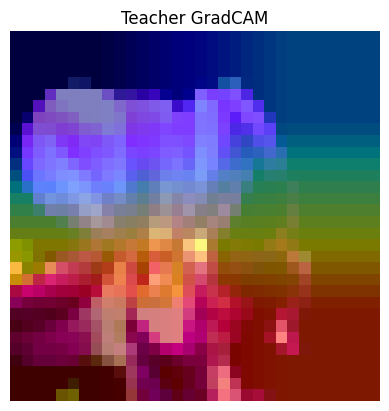

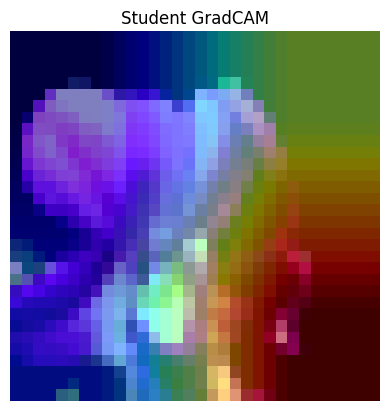

In [72]:
# Independent

student = models.vgg11(weights=None)
student.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_independent_best.pth', map_location=device)
student.load_state_dict(state_dict)

student = student.to(device)

# get one batch of images and labels
images, labels = next(iter(train_loader))

# take just one image
some_image_batch = images[:1].to(device)

compare_gradcam(
    teacher=teacher,
    student=student,
    img_tensor=some_image_batch,  # one image
    target_layer_t="features.28",  # last conv layer in VGG16
    target_layer_s="features.18",  # last conv layer in VGG11
)

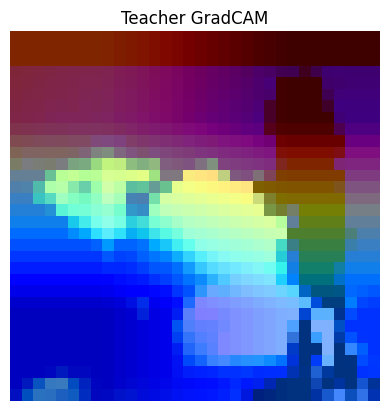

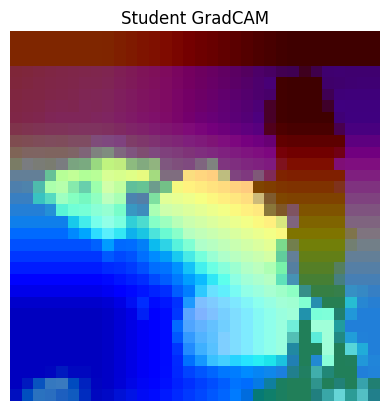

In [73]:
# Logit Matching

student = models.vgg11(weights=None)
student.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_LM_best.pth', map_location=device)
student.load_state_dict(state_dict)

student = student.to(device)

# get one batch of images and labels
images, labels = next(iter(train_loader))

# take just one image
some_image_batch = images[:1].to(device)

compare_gradcam(
    teacher=teacher,
    student=student,
    img_tensor=some_image_batch,  # one image
    target_layer_t="features.28",  # last conv layer in VGG16
    target_layer_s="features.18",  # last conv layer in VGG11
)

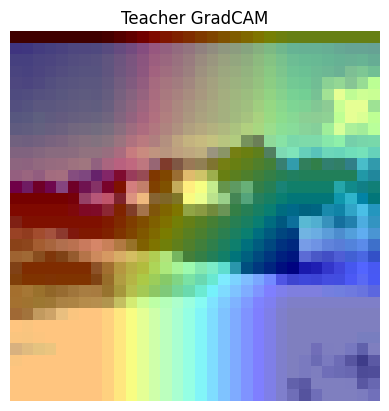

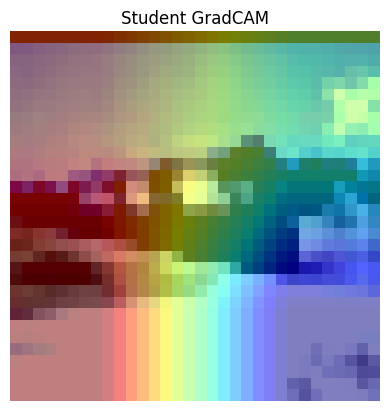

In [92]:
# DKD

student = models.vgg11(weights=None)
student.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_DKD_best.pth', map_location=device)
student.load_state_dict(state_dict)

student = student.to(device)

# get one batch of images and labels
images, labels = next(iter(train_loader))

# take just one image
some_image_batch = images[:1].to(device)

compare_gradcam(
    teacher=teacher,
    student=student,
    img_tensor=some_image_batch,  # one image
    target_layer_t="features.28",  # last conv layer in VGG16
    target_layer_s="features.18",  # last conv layer in VGG11
)

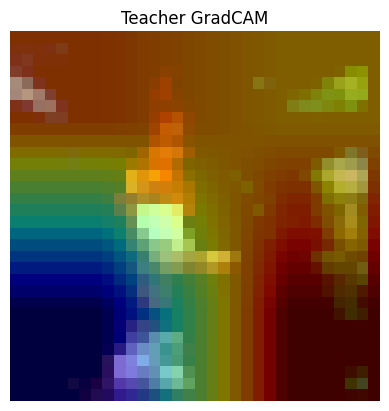

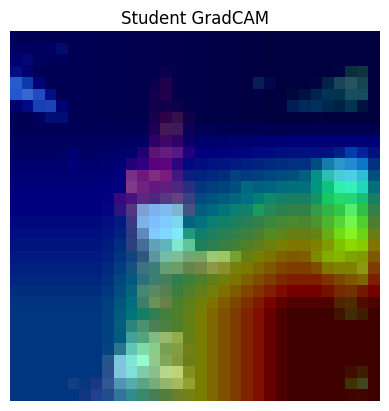

In [91]:
# Hint Losses

student = models.vgg11(weights=None)
student.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_FitNet_best.pth', map_location=device)
state_dict = {k: v for k, v in state_dict.items() if "hint_layer" not in k}
student.load_state_dict(state_dict)

student = student.to(device)

# get one batch of images and labels
images, labels = next(iter(train_loader))

# take just one image
some_image_batch = images[:1].to(device)

compare_gradcam(
    teacher=teacher,
    student=student,
    img_tensor=some_image_batch,  # one image
    target_layer_t="features.28",  # last conv layer in VGG16
    target_layer_s="features.18",  # last conv layer in VGG11
)

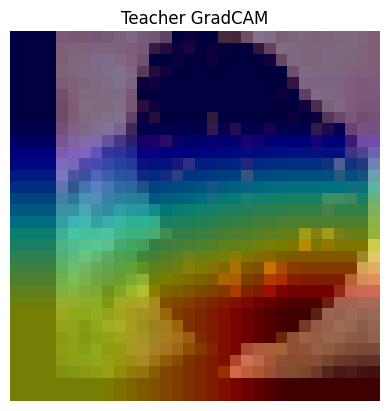

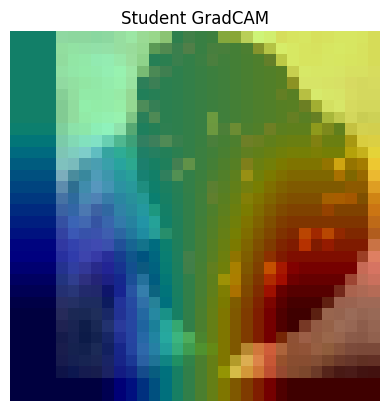

In [83]:
# CRD

student = models.vgg11(weights=None)
student.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_CRD_best.pth', map_location=device)
student.load_state_dict(state_dict)

student = student.to(device)

# get one batch of images and labels
images, labels = next(iter(train_loader))

# take just one image
some_image_batch = images[:1].to(device)

compare_gradcam(
    teacher=teacher,
    student=student,
    img_tensor=some_image_batch,  # one image
    target_layer_t="features.28",  # last conv layer in VGG16
    target_layer_s="features.18",  # last conv layer in VGG11
)

## Probability Distributions

In [93]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def compute_kl_divergence(p_logits, q_logits, T=1.0):
    """
    KL divergence D_KL(P || Q) between teacher P and student Q.
    Args:
        p_logits: teacher logits
        q_logits: student logits
        T: temperature
    Returns:
        mean KL divergence across the batch
    """
    p = F.log_softmax(p_logits / T, dim=1)
    q = F.softmax(q_logits / T, dim=1)
    kl = F.kl_div(p, q, reduction="batchmean")
    return kl.item()

def compare_teacher_student_distributions(teacher, students_dict, loader, device="cuda", T=4.0):
    """
    Compare teacher vs multiple students using KL divergence.
    Args:
        teacher: teacher model
        students_dict: dict of {name: model} for students
        loader: dataloader of evaluation images
        device: GPU/CPU
        T: temperature for softening
    Returns:
        dict of average KL divergence for each student
    """
    teacher.eval()
    for s in students_dict.values():
        s.eval()

    kl_results = {name: [] for name in students_dict.keys()}

    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Comparing distributions"):
            x = x.to(device)
            t_logits = teacher(x)

            for name, s_model in students_dict.items():
                s_logits = s_model(x)
                kl = compute_kl_divergence(t_logits, s_logits, T)
                kl_results[name].append(kl)

    # Average KL per student
    avg_kl = {name: np.mean(vals) for name, vals in kl_results.items()}
    return avg_kl

In [94]:
student_independent = models.vgg11(weights=None)
student_independent.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_independent_best.pth', map_location=device)
student_independent.load_state_dict(state_dict)

student_independent = student_independent.to(device)

student_logitmatching = models.vgg11(weights=None)
student_logitmatching.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_LM_best.pth', map_location=device)
student_logitmatching.load_state_dict(state_dict)

student_logitmatching = student_logitmatching.to(device)

student_dkd = models.vgg11(weights=None)
student_dkd.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_DKD_best.pth', map_location=device)
student_dkd.load_state_dict(state_dict)

student_dkd = student_dkd.to(device)

student_fitnet = models.vgg11(weights=None)
student_fitnet.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_FitNet_best.pth', map_location=device)
state_dict = {k: v for k, v in state_dict.items() if "hint_layer" not in k}
student_fitnet.load_state_dict(state_dict)

student_fitnet = student_fitnet.to(device)

student_crd = models.vgg11(weights=None)
student_crd.classifier[6] = nn.Linear(4096, 100)

state_dict = torch.load('/content/drive/MyDrive/kd_experiments/student_CRD_best.pth', map_location=device)
student_crd.load_state_dict(state_dict)

student_crd = student_crd.to(device)

In [95]:
students_dict = {
    "SI": student_independent,
    "SD_LM": student_logitmatching,
    "SD_DKD": student_dkd,
    "SD_Hints": student_fitnet,
    "SD_CRD": student_crd
}

avg_kl = compare_teacher_student_distributions(teacher, students_dict, test_loader, device=device, T=4.0)
print("Average KL divergence to teacher:", avg_kl)



Comparing distributions: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]

Average KL divergence to teacher: {'SI': np.float64(0.6000878897648824), 'SD_LM': np.float64(0.3380537904516051), 'SD_DKD': np.float64(0.22299200654784335), 'SD_Hints': np.float64(1.2625888480415828), 'SD_CRD': np.float64(0.3641026201127451)}


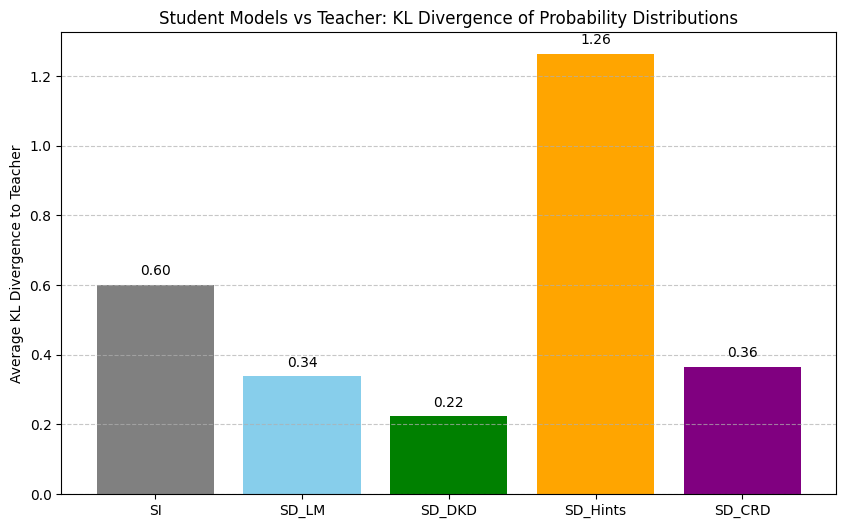

In [97]:
names = list(avg_kl.keys())
values = list(avg_kl.values())

plt.figure(figsize=(10,6))
bars = plt.bar(names, values, color=['gray', 'skyblue', 'green', 'orange', 'purple'])
plt.ylabel("Average KL Divergence to Teacher")
plt.title("Student Models vs Teacher: KL Divergence of Probability Distributions")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.show()

In [96]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def plot_teacher_student_probs(teacher, students_dict, images, class_names=None, device="cuda", T=4.0):
    """
    Plot probability distributions of teacher vs students for a batch of images.

    Args:
        teacher: teacher model
        students_dict: dict of {name: model}
        images: batch of images (B, C, H, W)
        class_names: optional list of class names for x-axis
        device: 'cuda' or 'cpu'
        T: temperature for softmax
    """
    teacher.eval()
    for s in students_dict.values():
        s.eval()

    images = images.to(device)

    with torch.no_grad():
        t_logits = teacher(images)
        t_probs = F.softmax(t_logits / T, dim=1).cpu()

        student_probs = {}
        for name, s_model in students_dict.items():
            s_logits = s_model(images)
            student_probs[name] = F.softmax(s_logits / T, dim=1).cpu()

    batch_size = images.size(0)

    for i in range(batch_size):
        plt.figure(figsize=(12, 6))
        x = range(t_probs.size(1))  # number of classes
        teacher_vals = t_probs[i].numpy()
        plt.plot(x, teacher_vals, label="Teacher", linewidth=2, color="black")

        for name, probs in student_probs.items():
            plt.plot(x, probs[i].numpy(), label=name, linewidth=1)

        plt.xlabel("Class" if class_names is None else "Class Name")
        plt.ylabel("Probability")
        plt.title(f"Image {i} Probabilities")
        plt.legend()
        plt.grid(True)
        plt.show()


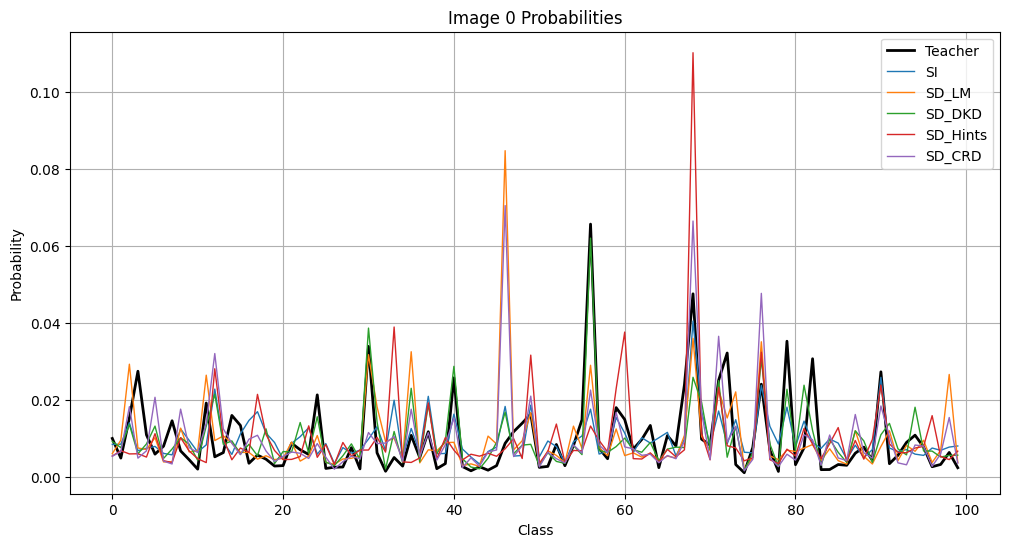

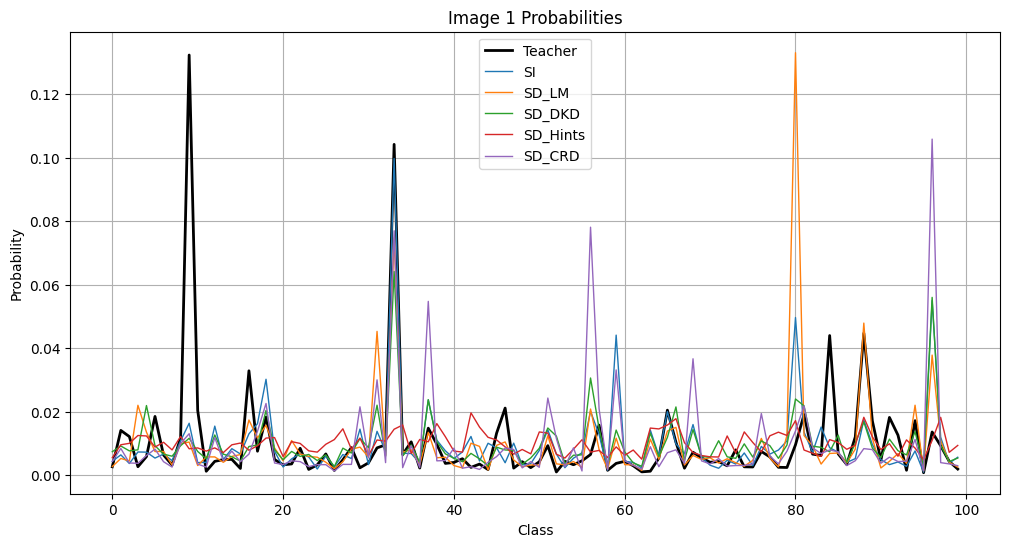

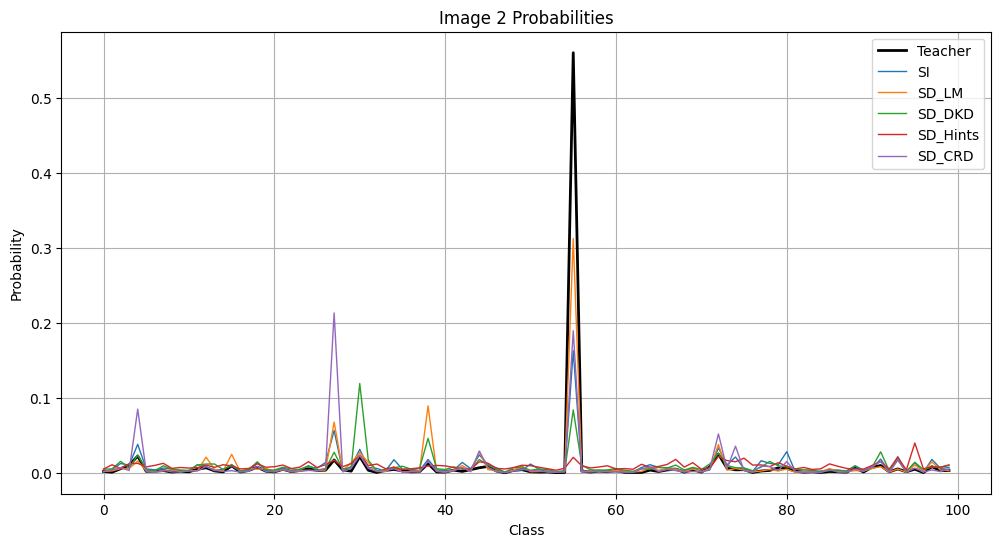

In [98]:
some_images, _ = next(iter(test_loader))
some_images = some_images[:3]

plot_teacher_student_probs(teacher, students_dict, some_images, device=device, T=4.0)